### Import Package Yang di Butuhkan

In [85]:
import pandas as pd
import numpy as np
import re
from flask import Flask , render_template , request, jsonify
from wordcloud import WordCloud
from matplotlib import pyplot as plt
import seaborn as sns
import sqlite3
from pathlib import Path

### Import CSV dan Cleaning

In [68]:
df = pd.read_table('train_preprocess.tsv.txt', header=None)
alay = pd.read_csv('new_kamusalay.csv' , encoding="latin-1", header=None)

In [69]:
df.columns = ['text','label']
alay.columns = ['awal','akhir']

In [70]:
alay_dict = dict(zip(alay["awal"], alay["akhir"]))
alay_dict

{'anakjakartaasikasik': 'anak jakarta asyik asyik',
 'pakcikdahtua': 'pak cik sudah tua',
 'pakcikmudalagi': 'pak cik muda lagi',
 't3tapjokowi': 'tetap jokowi',
 '3x': 'tiga kali',
 'aamiin': 'amin',
 'aamiinn': 'amin',
 'aamin': 'amin',
 'aammiin': 'amin',
 'abis': 'habis',
 'abisin': 'habiskan',
 'acau': 'kacau',
 'achok': 'ahok',
 'ad': 'ada',
 'adek': 'adik',
 'adl': 'adalah',
 'adlah': 'adalah',
 'adlh': 'adalah',
 'ado': 'ada',
 'aduhh': 'aduh',
 'aer': 'air',
 'afdol': 'afdal',
 'agamaataualqur': 'agama alquran',
 'agm': 'agama',
 'agma': 'agama',
 'ahaha': 'haha',
 'ahahaha': 'haha',
 'ahehehehe': 'hehe',
 'ahir': 'akhir',
 'ahirnya': 'akhirnya',
 'ahk': 'ahok',
 'ahlamdulillah': 'alhamdulillah',
 'ahli2': 'para ahli',
 'ahlusunnah': 'ahlus sunah',
 'ahmaddani': 'ahmad dhani',
 'aho': 'ahok',
 'ahoax': 'ahok',
 'ahoaxx': 'ahok',
 'ahog': 'ahok',
 'ahokataudjarot': 'ahok djarot',
 'ahokbebanijokowi': 'ahok beban jokowi',
 'ahokbtp': 'ahok basuki tjahaja purnama',
 'ahokditolakw

In [71]:
def hurufkecil(text):
    return text.lower()

def cleaningemoji(text):
    text = re.sub('\w*\d\w*', '', text)
    return text

def cleaningpertama(text):
    re.sub(r'[^a-zA-Z0-9]', ' ', text)
    text = re.sub('  +', ' ', text)
    return text

def cleaningkedua(text):
    text = re.sub('[^0-9a-zA-Z]+', ' ', text) 
    return text

def gantikataalay(text):
    return ' '.join([alay_dict[word] if word in alay_dict else word for word in text.split(' ')])


In [72]:
def semua_fungsi_API(text):
    text = hurufkecil(text)
    text = cleaningemoji(text)
    text = cleaningpertama(text)
    text = cleaningkedua(text)
    text = gantikataalay(text)
    return text

In [73]:
df['text_clean'] = df.text.apply(semua_fungsi_API)

In [74]:
neg = df.loc[df['label'] == 'negative'].text_clean.tolist()
neu = df.loc[df['label'] == 'neutral'].text_clean.tolist()
pos = df.loc[df['label'] == 'positive'].text_clean.tolist()

neg_label = df.loc[df['label'] == 'negative'].label.tolist()
neu_label = df.loc[df['label'] == 'neutral'].label.tolist()
pos_label = df.loc[df['label'] == 'positive'].label.tolist()

In [75]:
total_data = pos + neu + neg
labels = pos_label + neu_label + neg_label

print("Pos: %s, Neu: %s, Neg: %s" % (len(pos), len(neu), len(neg)))
print("Total data: %s" % len(total_data))

Pos: 6416, Neu: 1148, Neg: 3436
Total data: 11000


### Training

In [76]:
import pickle
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import defaultdict

max_features = 100000
tokenizer = Tokenizer(num_words=max_features, split=' ', lower=True)
tokenizer.fit_on_texts(total_data)
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("tokenizer.pickle has created!")

X = tokenizer.texts_to_sequences(total_data)

vocab_size = len(tokenizer.word_index)
maxlen = max(len(x) for x in X)

X = pad_sequences(X)
with open('x_pad_sequences.pickle', 'wb') as handle:
    pickle.dump(X, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("x_pad_sequences.pickle has created!")

tokenizer.pickle has created!
x_pad_sequences.pickle has created!


In [77]:
tokenizer

In [78]:
Y = pd.get_dummies(labels)
Y = Y.values

with open('y_labels.pickle', 'wb') as handle:
    pickle.dump(Y, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("y_labels.pickle has created!")

y_labels.pickle has created!


In [79]:
from sklearn.model_selection import train_test_split

file = open("x_pad_sequences.pickle",'rb')
X = pickle.load(file)
file.close()

file = open("y_labels.pickle",'rb')
Y = pickle.load(file)
file.close()

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

In [80]:
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, SimpleRNN, Activation
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.layers import Flatten
from tensorflow.keras import backend as K

In [81]:
embed_dim = 100
units = 64

model = Sequential()
model.add(Embedding(max_features, embed_dim, input_length=X.shape[1]))
model.add(LSTM(units, dropout=0.1))
model.add(Dense(3,activation='softmax'))
model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

adam = optimizers.Adam(lr = 0.00001)
model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
history = model.fit(X_train, y_train, epochs=10, batch_size=10, validation_data=(X_test, y_test), verbose=1, callbacks=[es])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 85, 100)           10000000  
                                                                 
 lstm (LSTM)                 (None, 64)                42240     
                                                                 
 dense (Dense)               (None, 3)                 195       
                                                                 
Total params: 10,042,435
Trainable params: 10,042,435
Non-trainable params: 0
_________________________________________________________________


None
Epoch 1/10
880/880 [==============================] - 269s 302ms/step - loss: 0.4475 - accuracy: 0.8216 - val_loss: 0.3460 - val_accuracy: 0.8777
Epoch 2/10
880/880 [==============================] - 245s 278ms/step - loss: 0.2023 - accuracy: 0.9228 - val_loss: 0.3222 - val_accuracy: 0.8823
Epoch 2: early stopping


In [90]:
from sklearn import metrics

predictions = model.predict(X_test)
y_pred = predictions
matrix_test = metrics.classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1))
print("Testing selesai")
print(matrix_test)

69/69 [==============================] - 6s 71ms/step
Testing selesai
              precision    recall  f1-score   support

           0       0.84      0.84      0.84       685
           1       0.81      0.79      0.80       233
           2       0.92      0.92      0.92      1282

    accuracy                           0.88      2200
   macro avg       0.86      0.85      0.85      2200
weighted avg       0.88      0.88      0.88      2200



In [52]:
# Untuk lebih menyakinkan lagi, kita juga bisa melakukan "Cross Validation"
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

kf = KFold(n_splits=5,random_state=42,shuffle=True)

accuracies = []

y = Y

embed_dim = 100
units = 64

for iteration, data in enumerate(kf.split(X), start=1):

    data_train   = X[data[0]]
    target_train = y[data[0]]

    data_test    = X[data[1]]
    target_test  = y[data[1]]


    model = Sequential()
    model.add(Embedding(max_features, embed_dim, input_length=X.shape[1]))
    model.add(LSTM(units, dropout=0.1))
    model.add(Dense(3,activation='softmax'))
    model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])

    adam = optimizers.Adam(lr = 0.001)
    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
    history = model.fit(X_train, y_train, epochs=10, batch_size=10, validation_data=(X_test, y_test), verbose=1, callbacks=[es])

    predictions = model.predict(X_test)
    y_pred = predictions

    # for the current fold only    
    accuracy = accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1))

    print("Training ke-", iteration)
    print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))
    print("======================================================")

    accuracies.append(accuracy)

# this is the average accuracy over all folds
average_accuracy = np.mean(accuracies)

print()
print()
print()
print("Rata-rata Accuracy: ", average_accuracy)

Epoch 1/10
880/880 [==============================] - 112s 125ms/step - loss: 0.4438 - accuracy: 0.8238 - val_loss: 0.3418 - val_accuracy: 0.8709
Epoch 2/10
880/880 [==============================] - 110s 125ms/step - loss: 0.2004 - accuracy: 0.9266 - val_loss: 0.3398 - val_accuracy: 0.8832
Epoch 2: early stopping
69/69 [==============================] - 1s 15ms/step
Training ke- 1
              precision    recall  f1-score   support

           0       0.85      0.84      0.84       685
           1       0.79      0.83      0.81       233
           2       0.92      0.91      0.92      1282

    accuracy                           0.88      2200
   macro avg       0.85      0.86      0.86      2200
weighted avg       0.88      0.88      0.88      2200



Epoch 1/10
880/880 [==============================] - 125s 140ms/step - loss: 0.4499 - accuracy: 0.8195 - val_loss: 0.3482 - val_accuracy: 0.8723
Epoch 2/10
880/880 [==============================] - 121s 138ms/step - loss: 0.2083 - accuracy: 0.9253 - val_loss: 0.3423 - val_accuracy: 0.8723
Epoch 2: early stopping
69/69 [==============================] - 2s 17ms/step
Training ke- 2
              precision    recall  f1-score   support

           0       0.83      0.82      0.82       685
           1       0.79      0.84      0.81       233
           2       0.91      0.91      0.91      1282

    accuracy                           0.87      2200
   macro avg       0.84      0.85      0.85      2200
weighted avg       0.87      0.87      0.87      2200



Epoch 1/10
880/880 [==============================] - 119s 134ms/step - loss: 0.4445 - accuracy: 0.8272 - val_loss: 0.3333 - val_accuracy: 0.8809
Epoch 2/10
880/880 [==============================] - 112s 127ms/step - loss: 0.1942 - accuracy: 0.9276 - val_loss: 0.3362 - val_accuracy: 0.8759
Epoch 2: early stopping
69/69 [==============================] - 1s 16ms/step
Training ke- 3
              precision    recall  f1-score   support

           0       0.83      0.85      0.84       685
           1       0.79      0.83      0.81       233
           2       0.92      0.90      0.91      1282

    accuracy                           0.88      2200
   macro avg       0.85      0.86      0.85      2200
weighted avg       0.88      0.88      0.88      2200



Epoch 1/10
880/880 [==============================] - 113s 127ms/step - loss: 0.4440 - accuracy: 0.8244 - val_loss: 0.3471 - val_accuracy: 0.8741
Epoch 2/10
880/880 [==============================] - 112s 127ms/step - loss: 0.2021 - accuracy: 0.9273 - val_loss: 0.3384 - val_accuracy: 0.8768
Epoch 2: early stopping
69/69 [==============================] - 1s 16ms/step
Training ke- 4
              precision    recall  f1-score   support

           0       0.85      0.81      0.83       685
           1       0.78      0.78      0.78       233
           2       0.91      0.93      0.92      1282

    accuracy                           0.88      2200
   macro avg       0.85      0.84      0.84      2200
weighted avg       0.88      0.88      0.88      2200



Epoch 1/10
880/880 [==============================] - 113s 127ms/step - loss: 0.4471 - accuracy: 0.8227 - val_loss: 0.3556 - val_accuracy: 0.8759
Epoch 2/10
880/880 [==============================] - 112s 127ms/step - loss: 0.2026 - accuracy: 0.9268 - val_loss: 0.3278 - val_accuracy: 0.8786
Epoch 2: early stopping
69/69 [==============================] - 2s 16ms/step
Training ke- 5
              precision    recall  f1-score   support

           0       0.85      0.80      0.83       685
           1       0.84      0.79      0.81       233
           2       0.90      0.93      0.92      1282

    accuracy                           0.88      2200
   macro avg       0.86      0.84      0.85      2200
weighted avg       0.88      0.88      0.88      2200




Rata-rata Accuracy:  0.8773636363636363


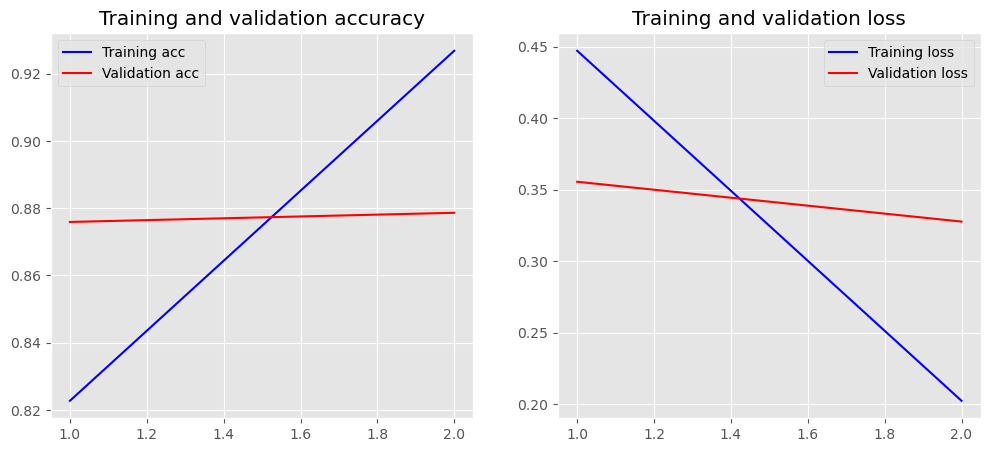

In [53]:
# history.history
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

%matplotlib inline
plot_history(history)

### Testing Model

In [33]:
df = pd.read_csv('data.csv', encoding='latin-1')

In [34]:
df = df[['Tweet','HS','Abusive']]
df.head()

,Tweet,HS,Abusive
0,- disaat semua cowok berusaha melacak perhatia...,1,1
1,RT USER: USER siapa yang telat ngasih tau elu?...,0,1
2,"41. Kadang aku berfikir, kenapa aku tetap perc...",0,0
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...,0,0
4,USER USER Kaum cebong kapir udah keliatan dong...,1,1


In [35]:
alay = pd.read_csv("new_kamusalay.csv" , encoding="latin-1", header=None)
alay.columns = ['awal','akhir']
alay_dict = dict(zip(alay["awal"], alay["akhir"]))

In [36]:
def hurufkecil(text):
    return text.lower()

def cleaningemoji(text):
    text = re.sub('\w*\d\w*', '', text)
    return text

def cleaningpertama(text):
    text = re.sub(r'\n', '', text)
    text = re.sub('url',' ', text)
    text = re.sub(r'^rt[\s]+', '', text)
    text = re.sub(r'@[A-Za-z0-9_]+', '', text)
    text = re.sub('user',' ', text)
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))',' ', text)
    text = re.sub('xd',' ', text)
    text = re.sub('  +', ' ', text)
    return text

def cleaningkedua(text):
    text = re.sub('[^0-9a-zA-Z]+', ' ', text) 
    return text

def gantikataalay(text):
    return ' '.join([alay_dict[word] if word in alay_dict else word for word in text.split(' ')])

In [37]:
def semua_fungsi_API1(text):
    text = hurufkecil(text)
    text = cleaningemoji(text)
    text = cleaningpertama(text)
    text = cleaningkedua(text)
    text = gantikataalay(text)
    return text

In [38]:
df.Tweet = df.Tweet.apply(semua_fungsi_API1)

In [41]:
df.head()

,Tweet,HS,Abusive
0,di saat semua cowok berusaha melacak perhatia...,1,1
1,siapa yang telat memberi tau kamu edan sarap ...,0,1
2,kadang aku berpikir kenapa aku tetap percaya ...,0,0
3,aku itu aku dan ku tau matamu sipit tapi dili...,0,0
4,kaum cebong kafir sudah kelihatan dongoknya d...,1,1


In [43]:
[df.Tweet[0]]

[' di saat semua cowok berusaha melacak perhatian gue kamu lantas remehkan perhatian yang gue kasih khusus ke kamu basic kamu cowok bego ']

In [53]:
import re 
from keras.models import load_model

pred = []
sentiment = ['negative', 'neutral', 'positive']
for j,i in enumerate(df.Tweet):
    predicted = tokenizer.texts_to_sequences([i])
    guess = pad_sequences(predicted, maxlen=X.shape[1])
    
    model = load_model('model/LSTM.h5')
    prediction = model.predict(guess)
    polarity = np.argmax(prediction[0])
    result = sentiment[polarity]
    pred.append(result)
    print(j)

1/1 [==============================] - 1s 1s/step
0
1/1 [==============================] - 1s 863ms/step
1
1/1 [==============================] - 1s 706ms/step
2
1/1 [==============================] - 1s 761ms/step
3
1/1 [==============================] - 1s 625ms/step
4
1/1 [==============================] - 1s 674ms/step
5
1/1 [==============================] - 1s 715ms/step
6
1/1 [==============================] - 1s 725ms/step
7
1/1 [==============================] - 1s 633ms/step
8
1/1 [==============================] - 1s 625ms/step
9
1/1 [==============================] - 1s 592ms/step
10
1/1 [==============================] - 1s 577ms/step
11
1/1 [==============================] - 1s 1s/step
12
1/1 [==============================] - 1s 576ms/step
13
1/1 [==============================] - 0s 425ms/step
14
1/1 [==============================] - 0s 412ms/step
15
1/1 [==============================] - 0s 422ms/step
16
1/1 [==============================] - 0s 410ms/step
17
1/1 [===

145
1/1 [==============================] - 0s 487ms/step
146
1/1 [==============================] - 1s 553ms/step
147
1/1 [==============================] - 0s 467ms/step
148
1/1 [==============================] - 0s 497ms/step
149
1/1 [==============================] - 0s 473ms/step
150
1/1 [==============================] - 1s 578ms/step
151
1/1 [==============================] - 0s 453ms/step
152
1/1 [==============================] - 0s 424ms/step
153
1/1 [==============================] - 1s 504ms/step
154
1/1 [==============================] - 0s 460ms/step
155
1/1 [==============================] - 0s 466ms/step
156
1/1 [==============================] - 0s 478ms/step
157
1/1 [==============================] - 0s 489ms/step
158
1/1 [==============================] - 0s 451ms/step
159
1/1 [==============================] - 0s 427ms/step
160
1/1 [==============================] - 0s 456ms/step
161
1/1 [==============================] - 0s 472ms/step
162
1/1 [======================

1/1 [==============================] - 1s 679ms/step
289
1/1 [==============================] - 1s 715ms/step
290
1/1 [==============================] - 1s 665ms/step
291
1/1 [==============================] - 1s 706ms/step
292
1/1 [==============================] - 1s 743ms/step
293
1/1 [==============================] - 1s 607ms/step
294
1/1 [==============================] - 1s 540ms/step
295
1/1 [==============================] - 1s 562ms/step
296
1/1 [==============================] - 1s 560ms/step
297
1/1 [==============================] - 1s 553ms/step
298
1/1 [==============================] - 1s 587ms/step
299
1/1 [==============================] - 1s 596ms/step
300
1/1 [==============================] - 0s 422ms/step
301
1/1 [==============================] - 0s 412ms/step
302
1/1 [==============================] - 0s 417ms/step
303
1/1 [==============================] - 0s 416ms/step
304
1/1 [==============================] - 0s 414ms/step
305
1/1 [==========================

1/1 [==============================] - 0s 415ms/step
432
1/1 [==============================] - 0s 425ms/step
433
1/1 [==============================] - 0s 416ms/step
434
1/1 [==============================] - 0s 426ms/step
435
1/1 [==============================] - 1s 520ms/step
436
1/1 [==============================] - 0s 435ms/step
437
1/1 [==============================] - 0s 439ms/step
438
1/1 [==============================] - 0s 421ms/step
439
1/1 [==============================] - 0s 419ms/step
440
1/1 [==============================] - 0s 424ms/step
441
1/1 [==============================] - 0s 418ms/step
442
1/1 [==============================] - 0s 425ms/step
443
1/1 [==============================] - 0s 412ms/step
444
1/1 [==============================] - 0s 411ms/step
445
1/1 [==============================] - 0s 421ms/step
446
1/1 [==============================] - 0s 422ms/step
447
1/1 [==============================] - 0s 428ms/step
448
1/1 [==========================

1/1 [==============================] - 0s 420ms/step
575
1/1 [==============================] - 0s 423ms/step
576
1/1 [==============================] - 0s 420ms/step
577
1/1 [==============================] - 0s 414ms/step
578
1/1 [==============================] - 0s 419ms/step
579
1/1 [==============================] - 0s 434ms/step
580
1/1 [==============================] - 0s 423ms/step
581
1/1 [==============================] - 0s 415ms/step
582
1/1 [==============================] - 0s 431ms/step
583
1/1 [==============================] - 1s 1s/step
584
1/1 [==============================] - 1s 866ms/step
585
1/1 [==============================] - 1s 800ms/step
586
1/1 [==============================] - 1s 702ms/step
587
1/1 [==============================] - 1s 774ms/step
588
1/1 [==============================] - 1s 609ms/step
589
1/1 [==============================] - 1s 667ms/step
590
1/1 [==============================] - 1s 681ms/step
591
1/1 [=============================

718
1/1 [==============================] - 0s 421ms/step
719
1/1 [==============================] - 0s 422ms/step
720
1/1 [==============================] - 0s 430ms/step
721
1/1 [==============================] - 0s 424ms/step
722
1/1 [==============================] - 0s 423ms/step
723
1/1 [==============================] - 0s 425ms/step
724
1/1 [==============================] - 0s 420ms/step
725
1/1 [==============================] - 0s 421ms/step
726
1/1 [==============================] - 0s 444ms/step
727
1/1 [==============================] - 0s 417ms/step
728
1/1 [==============================] - 0s 417ms/step
729
1/1 [==============================] - 0s 421ms/step
730
1/1 [==============================] - 0s 424ms/step
731
1/1 [==============================] - 0s 424ms/step
732
1/1 [==============================] - 0s 427ms/step
733
1/1 [==============================] - 0s 435ms/step
734
1/1 [==============================] - 0s 429ms/step
735
1/1 [======================

1/1 [==============================] - 0s 421ms/step
862
1/1 [==============================] - 0s 434ms/step
863
1/1 [==============================] - 0s 428ms/step
864
1/1 [==============================] - 0s 427ms/step
865
1/1 [==============================] - 0s 419ms/step
866
1/1 [==============================] - 0s 426ms/step
867
1/1 [==============================] - 0s 427ms/step
868
1/1 [==============================] - 0s 431ms/step
869
1/1 [==============================] - 0s 451ms/step
870
1/1 [==============================] - 0s 425ms/step
871
1/1 [==============================] - 0s 424ms/step
872
1/1 [==============================] - 0s 424ms/step
873
1/1 [==============================] - 0s 431ms/step
874
1/1 [==============================] - 0s 424ms/step
875
1/1 [==============================] - 0s 424ms/step
876
1/1 [==============================] - 0s 429ms/step
877
1/1 [==============================] - 0s 431ms/step
878
1/1 [==========================

1/1 [==============================] - 0s 426ms/step
1005
1/1 [==============================] - 0s 432ms/step
1006
1/1 [==============================] - 0s 421ms/step
1007
1/1 [==============================] - 0s 425ms/step
1008
1/1 [==============================] - 0s 422ms/step
1009
1/1 [==============================] - 0s 419ms/step
1010
1/1 [==============================] - 0s 426ms/step
1011
1/1 [==============================] - 0s 423ms/step
1012
1/1 [==============================] - 0s 441ms/step
1013
1/1 [==============================] - 0s 430ms/step
1014
1/1 [==============================] - 0s 433ms/step
1015
1/1 [==============================] - 0s 428ms/step
1016
1/1 [==============================] - 0s 426ms/step
1017
1/1 [==============================] - 0s 428ms/step
1018
1/1 [==============================] - 0s 426ms/step
1019
1/1 [==============================] - 0s 435ms/step
1020
1/1 [==============================] - 0s 431ms/step
1021
1/1 [=========

1/1 [==============================] - 0s 476ms/step
1146
1/1 [==============================] - 0s 460ms/step
1147
1/1 [==============================] - 1s 502ms/step
1148
1/1 [==============================] - 0s 470ms/step
1149
1/1 [==============================] - 0s 485ms/step
1150
1/1 [==============================] - 0s 470ms/step
1151
1/1 [==============================] - 0s 482ms/step
1152
1/1 [==============================] - 0s 497ms/step
1153
1/1 [==============================] - 0s 478ms/step
1154
1/1 [==============================] - 0s 482ms/step
1155
1/1 [==============================] - 0s 489ms/step
1156
1/1 [==============================] - 0s 487ms/step
1157
1/1 [==============================] - 1s 565ms/step
1158
1/1 [==============================] - 1s 548ms/step
1159
1/1 [==============================] - 0s 496ms/step
1160
1/1 [==============================] - 0s 482ms/step
1161
1/1 [==============================] - 0s 500ms/step
1162
1/1 [=========

1/1 [==============================] - 0s 481ms/step
1287
1/1 [==============================] - 0s 500ms/step
1288
1/1 [==============================] - 0s 470ms/step
1289
1/1 [==============================] - 0s 471ms/step
1290
1/1 [==============================] - 0s 477ms/step
1291
1/1 [==============================] - 0s 470ms/step
1292
1/1 [==============================] - 0s 478ms/step
1293
1/1 [==============================] - 0s 481ms/step
1294
1/1 [==============================] - 0s 489ms/step
1295
1/1 [==============================] - 0s 473ms/step
1296
1/1 [==============================] - 0s 486ms/step
1297
1/1 [==============================] - 0s 476ms/step
1298
1/1 [==============================] - 0s 499ms/step
1299
1/1 [==============================] - 0s 476ms/step
1300
1/1 [==============================] - 0s 479ms/step
1301
1/1 [==============================] - 0s 469ms/step
1302
1/1 [==============================] - 0s 488ms/step
1303
1/1 [=========

1/1 [==============================] - 0s 428ms/step
1428
1/1 [==============================] - 0s 423ms/step
1429
1/1 [==============================] - 0s 435ms/step
1430
1/1 [==============================] - 0s 427ms/step
1431
1/1 [==============================] - 0s 428ms/step
1432
1/1 [==============================] - 0s 432ms/step
1433
1/1 [==============================] - 0s 441ms/step
1434
1/1 [==============================] - 0s 439ms/step
1435
1/1 [==============================] - 0s 432ms/step
1436
1/1 [==============================] - 0s 434ms/step
1437
1/1 [==============================] - 0s 445ms/step
1438
1/1 [==============================] - 0s 434ms/step
1439
1/1 [==============================] - 0s 436ms/step
1440
1/1 [==============================] - 0s 433ms/step
1441
1/1 [==============================] - 0s 441ms/step
1442
1/1 [==============================] - 0s 430ms/step
1443
1/1 [==============================] - 0s 429ms/step
1444
1/1 [=========

1/1 [==============================] - 0s 425ms/step
1569
1/1 [==============================] - 0s 432ms/step
1570
1/1 [==============================] - 0s 432ms/step
1571
1/1 [==============================] - 0s 438ms/step
1572
1/1 [==============================] - 0s 432ms/step
1573
1/1 [==============================] - 0s 424ms/step
1574
1/1 [==============================] - 0s 439ms/step
1575
1/1 [==============================] - 0s 433ms/step
1576
1/1 [==============================] - 0s 431ms/step
1577
1/1 [==============================] - 0s 431ms/step
1578
1/1 [==============================] - 0s 436ms/step
1579
1/1 [==============================] - 0s 443ms/step
1580
1/1 [==============================] - 0s 438ms/step
1581
1/1 [==============================] - 0s 436ms/step
1582
1/1 [==============================] - 0s 454ms/step
1583
1/1 [==============================] - 0s 423ms/step
1584
1/1 [==============================] - 0s 437ms/step
1585
1/1 [=========

1/1 [==============================] - 0s 442ms/step
1710
1/1 [==============================] - 0s 427ms/step
1711
1/1 [==============================] - 0s 428ms/step
1712
1/1 [==============================] - 0s 434ms/step
1713
1/1 [==============================] - 0s 428ms/step
1714
1/1 [==============================] - 0s 430ms/step
1715
1/1 [==============================] - 0s 441ms/step
1716
1/1 [==============================] - 0s 466ms/step
1717
1/1 [==============================] - 0s 436ms/step
1718
1/1 [==============================] - 0s 438ms/step
1719
1/1 [==============================] - 0s 438ms/step
1720
1/1 [==============================] - 0s 445ms/step
1721
1/1 [==============================] - 0s 427ms/step
1722
1/1 [==============================] - 0s 430ms/step
1723
1/1 [==============================] - 0s 427ms/step
1724
1/1 [==============================] - 0s 434ms/step
1725
1/1 [==============================] - 0s 489ms/step
1726
1/1 [=========

1/1 [==============================] - 1s 710ms/step
1851
1/1 [==============================] - 0s 497ms/step
1852
1/1 [==============================] - 0s 440ms/step
1853
1/1 [==============================] - 0s 430ms/step
1854
1/1 [==============================] - 0s 439ms/step
1855
1/1 [==============================] - 0s 443ms/step
1856
1/1 [==============================] - 0s 442ms/step
1857
1/1 [==============================] - 0s 466ms/step
1858
1/1 [==============================] - 0s 444ms/step
1859
1/1 [==============================] - 0s 428ms/step
1860
1/1 [==============================] - 0s 460ms/step
1861
1/1 [==============================] - 0s 433ms/step
1862
1/1 [==============================] - 0s 438ms/step
1863
1/1 [==============================] - 0s 433ms/step
1864
1/1 [==============================] - 0s 431ms/step
1865
1/1 [==============================] - 0s 472ms/step
1866
1/1 [==============================] - 0s 448ms/step
1867
1/1 [=========

1/1 [==============================] - 0s 447ms/step
1992
1/1 [==============================] - 0s 441ms/step
1993
1/1 [==============================] - 0s 433ms/step
1994
1/1 [==============================] - 0s 432ms/step
1995
1/1 [==============================] - 0s 435ms/step
1996
1/1 [==============================] - 0s 468ms/step
1997
1/1 [==============================] - 0s 450ms/step
1998
1/1 [==============================] - 0s 442ms/step
1999
1/1 [==============================] - 0s 432ms/step
2000
1/1 [==============================] - 0s 449ms/step
2001
1/1 [==============================] - 0s 454ms/step
2002
1/1 [==============================] - 0s 437ms/step
2003
1/1 [==============================] - 0s 435ms/step
2004
1/1 [==============================] - 0s 437ms/step
2005
1/1 [==============================] - 0s 436ms/step
2006
1/1 [==============================] - 0s 436ms/step
2007
1/1 [==============================] - 0s 438ms/step
2008
1/1 [=========

1/1 [==============================] - 1s 667ms/step
2133
1/1 [==============================] - 1s 633ms/step
2134
1/1 [==============================] - 1s 674ms/step
2135
1/1 [==============================] - 1s 666ms/step
2136
1/1 [==============================] - 1s 646ms/step
2137
1/1 [==============================] - 1s 687ms/step
2138
1/1 [==============================] - 1s 671ms/step
2139
1/1 [==============================] - 1s 698ms/step
2140
1/1 [==============================] - 1s 717ms/step
2141
1/1 [==============================] - 0s 490ms/step
2142
1/1 [==============================] - 1s 623ms/step
2143
1/1 [==============================] - 0s 487ms/step
2144
1/1 [==============================] - 0s 443ms/step
2145
1/1 [==============================] - 0s 451ms/step
2146
1/1 [==============================] - 0s 436ms/step
2147
1/1 [==============================] - 0s 440ms/step
2148
1/1 [==============================] - 0s 433ms/step
2149
1/1 [=========

1/1 [==============================] - 0s 440ms/step
2274
1/1 [==============================] - 0s 438ms/step
2275
1/1 [==============================] - 0s 441ms/step
2276
1/1 [==============================] - 0s 439ms/step
2277
1/1 [==============================] - 0s 441ms/step
2278
1/1 [==============================] - 0s 435ms/step
2279
1/1 [==============================] - 0s 433ms/step
2280
1/1 [==============================] - 0s 442ms/step
2281
1/1 [==============================] - 0s 458ms/step
2282
1/1 [==============================] - 0s 434ms/step
2283
1/1 [==============================] - 0s 432ms/step
2284
1/1 [==============================] - 0s 432ms/step
2285
1/1 [==============================] - 0s 435ms/step
2286
1/1 [==============================] - 0s 439ms/step
2287
1/1 [==============================] - 0s 442ms/step
2288
1/1 [==============================] - 0s 431ms/step
2289
1/1 [==============================] - 0s 444ms/step
2290
1/1 [=========

1/1 [==============================] - 0s 451ms/step
2415
1/1 [==============================] - 0s 430ms/step
2416
1/1 [==============================] - 1s 1s/step
2417
1/1 [==============================] - 1s 908ms/step
2418
1/1 [==============================] - 1s 850ms/step
2419
1/1 [==============================] - 1s 699ms/step
2420
1/1 [==============================] - 1s 669ms/step
2421
1/1 [==============================] - 1s 633ms/step
2422
1/1 [==============================] - 1s 676ms/step
2423
1/1 [==============================] - 1s 678ms/step
2424
1/1 [==============================] - 1s 725ms/step
2425
1/1 [==============================] - 1s 632ms/step
2426
1/1 [==============================] - 1s 653ms/step
2427
1/1 [==============================] - 1s 643ms/step
2428
1/1 [==============================] - 1s 705ms/step
2429
1/1 [==============================] - 1s 646ms/step
2430
1/1 [==============================] - 1s 620ms/step
2431
1/1 [============

1/1 [==============================] - 0s 497ms/step
2556
1/1 [==============================] - 0s 499ms/step
2557
1/1 [==============================] - 0s 494ms/step
2558
1/1 [==============================] - 0s 480ms/step
2559
1/1 [==============================] - 0s 495ms/step
2560
1/1 [==============================] - 0s 493ms/step
2561
1/1 [==============================] - 1s 501ms/step
2562
1/1 [==============================] - 1s 507ms/step
2563
1/1 [==============================] - 0s 489ms/step
2564
1/1 [==============================] - 0s 489ms/step
2565
1/1 [==============================] - 1s 512ms/step
2566
1/1 [==============================] - 0s 476ms/step
2567
1/1 [==============================] - 0s 484ms/step
2568
1/1 [==============================] - 0s 490ms/step
2569
1/1 [==============================] - 0s 486ms/step
2570
1/1 [==============================] - 0s 482ms/step
2571
1/1 [==============================] - 0s 489ms/step
2572
1/1 [=========

1/1 [==============================] - 1s 770ms/step
2697
1/1 [==============================] - 1s 727ms/step
2698
1/1 [==============================] - 1s 760ms/step
2699
1/1 [==============================] - 1s 760ms/step
2700
1/1 [==============================] - 1s 824ms/step
2701
1/1 [==============================] - 1s 581ms/step
2702
1/1 [==============================] - 1s 559ms/step
2703
1/1 [==============================] - 1s 562ms/step
2704
1/1 [==============================] - 1s 589ms/step
2705
1/1 [==============================] - 0s 478ms/step
2706
1/1 [==============================] - 0s 480ms/step
2707
1/1 [==============================] - 0s 475ms/step
2708
1/1 [==============================] - 1s 513ms/step
2709
1/1 [==============================] - 0s 482ms/step
2710
1/1 [==============================] - 0s 491ms/step
2711
1/1 [==============================] - 0s 485ms/step
2712
1/1 [==============================] - 1s 508ms/step
2713
1/1 [=========

1/1 [==============================] - 0s 436ms/step
2838
1/1 [==============================] - 0s 448ms/step
2839
1/1 [==============================] - 0s 451ms/step
2840
1/1 [==============================] - 0s 445ms/step
2841
1/1 [==============================] - 0s 444ms/step
2842
1/1 [==============================] - 0s 450ms/step
2843
1/1 [==============================] - 0s 472ms/step
2844
1/1 [==============================] - 0s 456ms/step
2845
1/1 [==============================] - 0s 435ms/step
2846
1/1 [==============================] - 0s 455ms/step
2847
1/1 [==============================] - 0s 456ms/step
2848
1/1 [==============================] - 0s 449ms/step
2849
1/1 [==============================] - 0s 444ms/step
2850
1/1 [==============================] - 0s 456ms/step
2851
1/1 [==============================] - 0s 440ms/step
2852
1/1 [==============================] - 0s 449ms/step
2853
1/1 [==============================] - 0s 435ms/step
2854
1/1 [=========

1/1 [==============================] - 1s 518ms/step
2979
1/1 [==============================] - 1s 517ms/step
2980
1/1 [==============================] - 0s 493ms/step
2981
1/1 [==============================] - 0s 438ms/step
2982
1/1 [==============================] - 0s 444ms/step
2983
1/1 [==============================] - 0s 435ms/step
2984
1/1 [==============================] - 0s 447ms/step
2985
1/1 [==============================] - 0s 428ms/step
2986
1/1 [==============================] - 0s 440ms/step
2987
1/1 [==============================] - 0s 468ms/step
2988
1/1 [==============================] - 0s 433ms/step
2989
1/1 [==============================] - 0s 440ms/step
2990
1/1 [==============================] - 0s 429ms/step
2991
1/1 [==============================] - 0s 442ms/step
2992
1/1 [==============================] - 0s 443ms/step
2993
1/1 [==============================] - 0s 466ms/step
2994
1/1 [==============================] - 0s 446ms/step
2995
1/1 [=========

1/1 [==============================] - 0s 463ms/step
3120
1/1 [==============================] - 0s 439ms/step
3121
1/1 [==============================] - 0s 441ms/step
3122
1/1 [==============================] - 0s 441ms/step
3123
1/1 [==============================] - 0s 427ms/step
3124
1/1 [==============================] - 0s 435ms/step
3125
1/1 [==============================] - 0s 442ms/step
3126
1/1 [==============================] - 0s 441ms/step
3127
1/1 [==============================] - 0s 436ms/step
3128
1/1 [==============================] - 0s 439ms/step
3129
1/1 [==============================] - 0s 438ms/step
3130
1/1 [==============================] - 0s 432ms/step
3131
1/1 [==============================] - 0s 452ms/step
3132
1/1 [==============================] - 0s 440ms/step
3133
1/1 [==============================] - 0s 443ms/step
3134
1/1 [==============================] - 0s 436ms/step
3135
1/1 [==============================] - 0s 453ms/step
3136
1/1 [=========

1/1 [==============================] - 1s 677ms/step
3261
1/1 [==============================] - 1s 657ms/step
3262
1/1 [==============================] - 1s 645ms/step
3263
1/1 [==============================] - 0s 495ms/step
3264
1/1 [==============================] - 1s 533ms/step
3265
1/1 [==============================] - 1s 546ms/step
3266
1/1 [==============================] - 1s 534ms/step
3267
1/1 [==============================] - 1s 573ms/step
3268
1/1 [==============================] - 1s 505ms/step
3269
1/1 [==============================] - 0s 450ms/step
3270
1/1 [==============================] - 0s 434ms/step
3271
1/1 [==============================] - 0s 443ms/step
3272
1/1 [==============================] - 0s 435ms/step
3273
1/1 [==============================] - 1s 519ms/step
3274
1/1 [==============================] - 0s 451ms/step
3275
1/1 [==============================] - 1s 542ms/step
3276
1/1 [==============================] - 1s 564ms/step
3277
1/1 [=========

1/1 [==============================] - 0s 436ms/step
3402
1/1 [==============================] - 0s 440ms/step
3403
1/1 [==============================] - 0s 434ms/step
3404
1/1 [==============================] - 0s 446ms/step
3405
1/1 [==============================] - 0s 451ms/step
3406
1/1 [==============================] - 0s 437ms/step
3407
1/1 [==============================] - 0s 456ms/step
3408
1/1 [==============================] - 0s 431ms/step
3409
1/1 [==============================] - 0s 443ms/step
3410
1/1 [==============================] - 0s 432ms/step
3411
1/1 [==============================] - 0s 434ms/step
3412
1/1 [==============================] - 0s 474ms/step
3413
1/1 [==============================] - 0s 434ms/step
3414
1/1 [==============================] - 0s 445ms/step
3415
1/1 [==============================] - 0s 444ms/step
3416
1/1 [==============================] - 0s 450ms/step
3417
1/1 [==============================] - 0s 436ms/step
3418
1/1 [=========

1/1 [==============================] - 1s 637ms/step
3543
1/1 [==============================] - 1s 673ms/step
3544
1/1 [==============================] - 1s 663ms/step
3545
1/1 [==============================] - 1s 667ms/step
3546
1/1 [==============================] - 1s 656ms/step
3547
1/1 [==============================] - 1s 595ms/step
3548
1/1 [==============================] - 0s 494ms/step
3549
1/1 [==============================] - 1s 508ms/step
3550
1/1 [==============================] - 1s 544ms/step
3551
1/1 [==============================] - 1s 523ms/step
3552
1/1 [==============================] - 0s 500ms/step
3553
1/1 [==============================] - 0s 498ms/step
3554
1/1 [==============================] - 1s 513ms/step
3555
1/1 [==============================] - 0s 437ms/step
3556
1/1 [==============================] - 0s 449ms/step
3557
1/1 [==============================] - 0s 460ms/step
3558
1/1 [==============================] - 0s 435ms/step
3559
1/1 [=========

1/1 [==============================] - 0s 463ms/step
3684
1/1 [==============================] - 0s 495ms/step
3685
1/1 [==============================] - 0s 494ms/step
3686
1/1 [==============================] - 0s 430ms/step
3687
1/1 [==============================] - 0s 447ms/step
3688
1/1 [==============================] - 0s 442ms/step
3689
1/1 [==============================] - 0s 465ms/step
3690
1/1 [==============================] - 0s 441ms/step
3691
1/1 [==============================] - 0s 441ms/step
3692
1/1 [==============================] - 0s 428ms/step
3693
1/1 [==============================] - 0s 438ms/step
3694
1/1 [==============================] - 0s 429ms/step
3695
1/1 [==============================] - 0s 444ms/step
3696
1/1 [==============================] - 0s 436ms/step
3697
1/1 [==============================] - 0s 438ms/step
3698
1/1 [==============================] - 0s 432ms/step
3699
1/1 [==============================] - 0s 433ms/step
3700
1/1 [=========

1/1 [==============================] - 1s 605ms/step
3825
1/1 [==============================] - 1s 593ms/step
3826
1/1 [==============================] - 1s 600ms/step
3827
1/1 [==============================] - 1s 615ms/step
3828
1/1 [==============================] - 1s 582ms/step
3829
1/1 [==============================] - 1s 597ms/step
3830
1/1 [==============================] - 1s 595ms/step
3831
1/1 [==============================] - 1s 577ms/step
3832
1/1 [==============================] - 1s 561ms/step
3833
1/1 [==============================] - 1s 577ms/step
3834
1/1 [==============================] - 0s 486ms/step
3835
1/1 [==============================] - 0s 435ms/step
3836
1/1 [==============================] - 0s 442ms/step
3837
1/1 [==============================] - 0s 433ms/step
3838
1/1 [==============================] - 0s 439ms/step
3839
1/1 [==============================] - 0s 441ms/step
3840
1/1 [==============================] - 0s 434ms/step
3841
1/1 [=========

1/1 [==============================] - 0s 446ms/step
3966
1/1 [==============================] - 0s 433ms/step
3967
1/1 [==============================] - 0s 442ms/step
3968
1/1 [==============================] - 0s 442ms/step
3969
1/1 [==============================] - 0s 454ms/step
3970
1/1 [==============================] - 0s 445ms/step
3971
1/1 [==============================] - 0s 434ms/step
3972
1/1 [==============================] - 0s 454ms/step
3973
1/1 [==============================] - 0s 447ms/step
3974
1/1 [==============================] - 0s 432ms/step
3975
1/1 [==============================] - 0s 437ms/step
3976
1/1 [==============================] - 0s 442ms/step
3977
1/1 [==============================] - 0s 446ms/step
3978
1/1 [==============================] - 0s 430ms/step
3979
1/1 [==============================] - 0s 439ms/step
3980
1/1 [==============================] - 0s 428ms/step
3981
1/1 [==============================] - 0s 434ms/step
3982
1/1 [=========

1/1 [==============================] - 0s 445ms/step
4107
1/1 [==============================] - 0s 441ms/step
4108
1/1 [==============================] - 0s 435ms/step
4109
1/1 [==============================] - 0s 449ms/step
4110
1/1 [==============================] - 0s 439ms/step
4111
1/1 [==============================] - 0s 436ms/step
4112
1/1 [==============================] - 0s 454ms/step
4113
1/1 [==============================] - 0s 444ms/step
4114
1/1 [==============================] - 0s 438ms/step
4115
1/1 [==============================] - 0s 439ms/step
4116
1/1 [==============================] - 1s 838ms/step
4117
1/1 [==============================] - 1s 839ms/step
4118
1/1 [==============================] - 1s 630ms/step
4119
1/1 [==============================] - 1s 652ms/step
4120
1/1 [==============================] - 1s 569ms/step
4121
1/1 [==============================] - 1s 570ms/step
4122
1/1 [==============================] - 1s 574ms/step
4123
1/1 [=========

1/1 [==============================] - 0s 450ms/step
4248
1/1 [==============================] - 0s 436ms/step
4249
1/1 [==============================] - 0s 458ms/step
4250
1/1 [==============================] - 0s 452ms/step
4251
1/1 [==============================] - 0s 444ms/step
4252
1/1 [==============================] - 1s 541ms/step
4253
1/1 [==============================] - 0s 434ms/step
4254
1/1 [==============================] - 0s 437ms/step
4255
1/1 [==============================] - 0s 445ms/step
4256
1/1 [==============================] - 0s 444ms/step
4257
1/1 [==============================] - 0s 451ms/step
4258
1/1 [==============================] - 0s 438ms/step
4259
1/1 [==============================] - 0s 431ms/step
4260
1/1 [==============================] - 0s 441ms/step
4261
1/1 [==============================] - 0s 429ms/step
4262
1/1 [==============================] - 0s 451ms/step
4263
1/1 [==============================] - 0s 483ms/step
4264
1/1 [=========

1/1 [==============================] - 0s 438ms/step
4389
1/1 [==============================] - 0s 441ms/step
4390
1/1 [==============================] - 0s 481ms/step
4391
1/1 [==============================] - 0s 440ms/step
4392
1/1 [==============================] - 0s 440ms/step
4393
1/1 [==============================] - 0s 442ms/step
4394
1/1 [==============================] - 0s 445ms/step
4395
1/1 [==============================] - 0s 437ms/step
4396
1/1 [==============================] - 0s 436ms/step
4397
1/1 [==============================] - 0s 433ms/step
4398
1/1 [==============================] - 0s 440ms/step
4399
1/1 [==============================] - 0s 447ms/step
4400
1/1 [==============================] - 0s 429ms/step
4401
1/1 [==============================] - 0s 434ms/step
4402
1/1 [==============================] - 0s 429ms/step
4403
1/1 [==============================] - 0s 437ms/step
4404
1/1 [==============================] - 0s 458ms/step
4405
1/1 [=========

1/1 [==============================] - 0s 446ms/step
4530
1/1 [==============================] - 0s 433ms/step
4531
1/1 [==============================] - 0s 451ms/step
4532
1/1 [==============================] - 0s 457ms/step
4533
1/1 [==============================] - 0s 443ms/step
4534
1/1 [==============================] - 0s 470ms/step
4535
1/1 [==============================] - 0s 442ms/step
4536
1/1 [==============================] - 0s 465ms/step
4537
1/1 [==============================] - 0s 441ms/step
4538
1/1 [==============================] - 0s 440ms/step
4539
1/1 [==============================] - 0s 437ms/step
4540
1/1 [==============================] - 0s 430ms/step
4541
1/1 [==============================] - 0s 438ms/step
4542
1/1 [==============================] - 0s 437ms/step
4543
1/1 [==============================] - 0s 440ms/step
4544
1/1 [==============================] - 0s 438ms/step
4545
1/1 [==============================] - 0s 435ms/step
4546
1/1 [=========

1/1 [==============================] - 0s 438ms/step
4671
1/1 [==============================] - 0s 438ms/step
4672
1/1 [==============================] - 0s 445ms/step
4673
1/1 [==============================] - 0s 430ms/step
4674
1/1 [==============================] - 0s 435ms/step
4675
1/1 [==============================] - 0s 429ms/step
4676
1/1 [==============================] - 0s 445ms/step
4677
1/1 [==============================] - 0s 486ms/step
4678
1/1 [==============================] - 0s 441ms/step
4679
1/1 [==============================] - 0s 438ms/step
4680
1/1 [==============================] - 0s 436ms/step
4681
1/1 [==============================] - 0s 441ms/step
4682
1/1 [==============================] - 0s 433ms/step
4683
1/1 [==============================] - 0s 452ms/step
4684
1/1 [==============================] - 0s 439ms/step
4685
1/1 [==============================] - 0s 436ms/step
4686
1/1 [==============================] - 0s 434ms/step
4687
1/1 [=========

1/1 [==============================] - 1s 583ms/step
4812
1/1 [==============================] - 1s 570ms/step
4813
1/1 [==============================] - 1s 589ms/step
4814
1/1 [==============================] - 1s 595ms/step
4815
1/1 [==============================] - 1s 578ms/step
4816
1/1 [==============================] - 1s 584ms/step
4817
1/1 [==============================] - 1s 588ms/step
4818
1/1 [==============================] - 0s 437ms/step
4819
1/1 [==============================] - 0s 443ms/step
4820
1/1 [==============================] - 0s 438ms/step
4821
1/1 [==============================] - 0s 426ms/step
4822
1/1 [==============================] - 0s 434ms/step
4823
1/1 [==============================] - 0s 459ms/step
4824
1/1 [==============================] - 0s 435ms/step
4825
1/1 [==============================] - 0s 448ms/step
4826
1/1 [==============================] - 0s 437ms/step
4827
1/1 [==============================] - 0s 439ms/step
4828
1/1 [=========

1/1 [==============================] - 0s 442ms/step
4953
1/1 [==============================] - 0s 442ms/step
4954
1/1 [==============================] - 0s 442ms/step
4955
1/1 [==============================] - 0s 445ms/step
4956
1/1 [==============================] - 0s 428ms/step
4957
1/1 [==============================] - 0s 467ms/step
4958
1/1 [==============================] - 0s 427ms/step
4959
1/1 [==============================] - 0s 446ms/step
4960
1/1 [==============================] - 0s 436ms/step
4961
1/1 [==============================] - 0s 446ms/step
4962
1/1 [==============================] - 0s 441ms/step
4963
1/1 [==============================] - 0s 439ms/step
4964
1/1 [==============================] - 0s 442ms/step
4965
1/1 [==============================] - 0s 436ms/step
4966
1/1 [==============================] - 0s 447ms/step
4967
1/1 [==============================] - 0s 447ms/step
4968
1/1 [==============================] - 0s 450ms/step
4969
1/1 [=========

1/1 [==============================] - 0s 451ms/step
5094
1/1 [==============================] - 0s 443ms/step
5095
1/1 [==============================] - 0s 451ms/step
5096
1/1 [==============================] - 0s 443ms/step
5097
1/1 [==============================] - 0s 436ms/step
5098
1/1 [==============================] - 0s 495ms/step
5099
1/1 [==============================] - 1s 836ms/step
5100
1/1 [==============================] - 1s 674ms/step
5101
1/1 [==============================] - 1s 610ms/step
5102
1/1 [==============================] - 1s 608ms/step
5103
1/1 [==============================] - 1s 607ms/step
5104
1/1 [==============================] - 1s 564ms/step
5105
1/1 [==============================] - 1s 574ms/step
5106
1/1 [==============================] - 1s 575ms/step
5107
1/1 [==============================] - 1s 598ms/step
5108
1/1 [==============================] - 1s 568ms/step
5109
1/1 [==============================] - 1s 600ms/step
5110
1/1 [=========

1/1 [==============================] - 0s 461ms/step
5235
1/1 [==============================] - 0s 435ms/step
5236
1/1 [==============================] - 0s 481ms/step
5237
1/1 [==============================] - 0s 438ms/step
5238
1/1 [==============================] - 0s 453ms/step
5239
1/1 [==============================] - 0s 432ms/step
5240
1/1 [==============================] - 0s 441ms/step
5241
1/1 [==============================] - 0s 435ms/step
5242
1/1 [==============================] - 0s 430ms/step
5243
1/1 [==============================] - 0s 461ms/step
5244
1/1 [==============================] - 0s 429ms/step
5245
1/1 [==============================] - 0s 456ms/step
5246
1/1 [==============================] - 0s 450ms/step
5247
1/1 [==============================] - 0s 450ms/step
5248
1/1 [==============================] - 0s 440ms/step
5249
1/1 [==============================] - 0s 443ms/step
5250
1/1 [==============================] - 0s 463ms/step
5251
1/1 [=========

1/1 [==============================] - 0s 441ms/step
5376
1/1 [==============================] - 0s 443ms/step
5377
1/1 [==============================] - 0s 459ms/step
5378
1/1 [==============================] - 0s 435ms/step
5379
1/1 [==============================] - 0s 443ms/step
5380
1/1 [==============================] - 0s 444ms/step
5381
1/1 [==============================] - 0s 452ms/step
5382
1/1 [==============================] - 0s 434ms/step
5383
1/1 [==============================] - 0s 448ms/step
5384
1/1 [==============================] - 0s 453ms/step
5385
1/1 [==============================] - 0s 446ms/step
5386
1/1 [==============================] - 0s 438ms/step
5387
1/1 [==============================] - 0s 447ms/step
5388
1/1 [==============================] - 0s 443ms/step
5389
1/1 [==============================] - 0s 442ms/step
5390
1/1 [==============================] - 0s 442ms/step
5391
1/1 [==============================] - 1s 1s/step
5392
1/1 [============

1/1 [==============================] - 0s 447ms/step
5517
1/1 [==============================] - 0s 441ms/step
5518
1/1 [==============================] - 0s 436ms/step
5519
1/1 [==============================] - 0s 434ms/step
5520
1/1 [==============================] - 0s 430ms/step
5521
1/1 [==============================] - 0s 455ms/step
5522
1/1 [==============================] - 0s 457ms/step
5523
1/1 [==============================] - 0s 436ms/step
5524
1/1 [==============================] - 0s 442ms/step
5525
1/1 [==============================] - 0s 477ms/step
5526
1/1 [==============================] - 0s 439ms/step
5527
1/1 [==============================] - 0s 442ms/step
5528
1/1 [==============================] - 0s 463ms/step
5529
1/1 [==============================] - 0s 442ms/step
5530
1/1 [==============================] - 0s 445ms/step
5531
1/1 [==============================] - 0s 453ms/step
5532
1/1 [==============================] - 0s 453ms/step
5533
1/1 [=========

1/1 [==============================] - 0s 471ms/step
5658
1/1 [==============================] - 0s 435ms/step
5659
1/1 [==============================] - 0s 437ms/step
5660
1/1 [==============================] - 0s 437ms/step
5661
1/1 [==============================] - 0s 448ms/step
5662
1/1 [==============================] - 0s 454ms/step
5663
1/1 [==============================] - 0s 446ms/step
5664
1/1 [==============================] - 0s 455ms/step
5665
1/1 [==============================] - 0s 437ms/step
5666
1/1 [==============================] - 0s 435ms/step
5667
1/1 [==============================] - 0s 442ms/step
5668
1/1 [==============================] - 0s 436ms/step
5669
1/1 [==============================] - 0s 455ms/step
5670
1/1 [==============================] - 0s 452ms/step
5671
1/1 [==============================] - 0s 455ms/step
5672
1/1 [==============================] - 0s 442ms/step
5673
1/1 [==============================] - 0s 452ms/step
5674
1/1 [=========

1/1 [==============================] - 0s 456ms/step
5799
1/1 [==============================] - 0s 469ms/step
5800
1/1 [==============================] - 0s 435ms/step
5801
1/1 [==============================] - 0s 440ms/step
5802
1/1 [==============================] - 0s 449ms/step
5803
1/1 [==============================] - 0s 443ms/step
5804
1/1 [==============================] - 0s 437ms/step
5805
1/1 [==============================] - 0s 443ms/step
5806
1/1 [==============================] - 0s 439ms/step
5807
1/1 [==============================] - 0s 442ms/step
5808
1/1 [==============================] - 0s 454ms/step
5809
1/1 [==============================] - 0s 451ms/step
5810
1/1 [==============================] - 0s 455ms/step
5811
1/1 [==============================] - 0s 445ms/step
5812
1/1 [==============================] - 0s 456ms/step
5813
1/1 [==============================] - 0s 458ms/step
5814
1/1 [==============================] - 0s 441ms/step
5815
1/1 [=========

1/1 [==============================] - 0s 437ms/step
5940
1/1 [==============================] - 0s 442ms/step
5941
1/1 [==============================] - 0s 436ms/step
5942
1/1 [==============================] - 0s 446ms/step
5943
1/1 [==============================] - 0s 449ms/step
5944
1/1 [==============================] - 0s 453ms/step
5945
1/1 [==============================] - 0s 441ms/step
5946
1/1 [==============================] - 1s 518ms/step
5947
1/1 [==============================] - 0s 482ms/step
5948
1/1 [==============================] - 0s 443ms/step
5949
1/1 [==============================] - 0s 461ms/step
5950
1/1 [==============================] - 0s 448ms/step
5951
1/1 [==============================] - 0s 453ms/step
5952
1/1 [==============================] - 0s 443ms/step
5953
1/1 [==============================] - 0s 443ms/step
5954
1/1 [==============================] - 0s 447ms/step
5955
1/1 [==============================] - 0s 453ms/step
5956
1/1 [=========

1/1 [==============================] - 1s 599ms/step
6081
1/1 [==============================] - 1s 586ms/step
6082
1/1 [==============================] - 1s 575ms/step
6083
1/1 [==============================] - 1s 588ms/step
6084
1/1 [==============================] - 1s 548ms/step
6085
1/1 [==============================] - 0s 445ms/step
6086
1/1 [==============================] - 0s 443ms/step
6087
1/1 [==============================] - 0s 452ms/step
6088
1/1 [==============================] - 0s 442ms/step
6089
1/1 [==============================] - 0s 447ms/step
6090
1/1 [==============================] - 0s 452ms/step
6091
1/1 [==============================] - 0s 450ms/step
6092
1/1 [==============================] - 0s 454ms/step
6093
1/1 [==============================] - 0s 462ms/step
6094
1/1 [==============================] - 0s 453ms/step
6095
1/1 [==============================] - 0s 444ms/step
6096
1/1 [==============================] - 0s 438ms/step
6097
1/1 [=========

1/1 [==============================] - 0s 457ms/step
6222
1/1 [==============================] - 0s 441ms/step
6223
1/1 [==============================] - 0s 442ms/step
6224
1/1 [==============================] - 0s 442ms/step
6225
1/1 [==============================] - 0s 437ms/step
6226
1/1 [==============================] - 0s 457ms/step
6227
1/1 [==============================] - 0s 456ms/step
6228
1/1 [==============================] - 0s 438ms/step
6229
1/1 [==============================] - 0s 494ms/step
6230
1/1 [==============================] - 0s 443ms/step
6231
1/1 [==============================] - 0s 448ms/step
6232
1/1 [==============================] - 0s 448ms/step
6233
1/1 [==============================] - 0s 475ms/step
6234
1/1 [==============================] - 0s 437ms/step
6235
1/1 [==============================] - 0s 442ms/step
6236
1/1 [==============================] - 0s 443ms/step
6237
1/1 [==============================] - 0s 449ms/step
6238
1/1 [=========

1/1 [==============================] - 1s 841ms/step
6363
1/1 [==============================] - 1s 689ms/step
6364
1/1 [==============================] - 1s 613ms/step
6365
1/1 [==============================] - 1s 624ms/step
6366
1/1 [==============================] - 1s 573ms/step
6367
1/1 [==============================] - 1s 591ms/step
6368
1/1 [==============================] - 1s 593ms/step
6369
1/1 [==============================] - 1s 603ms/step
6370
1/1 [==============================] - 1s 622ms/step
6371
1/1 [==============================] - 1s 605ms/step
6372
1/1 [==============================] - 1s 586ms/step
6373
1/1 [==============================] - 1s 615ms/step
6374
1/1 [==============================] - 1s 578ms/step
6375
1/1 [==============================] - 1s 602ms/step
6376
1/1 [==============================] - 0s 488ms/step
6377
1/1 [==============================] - 0s 455ms/step
6378
1/1 [==============================] - 0s 441ms/step
6379
1/1 [=========

1/1 [==============================] - 0s 441ms/step
6504
1/1 [==============================] - 0s 435ms/step
6505
1/1 [==============================] - 0s 441ms/step
6506
1/1 [==============================] - 0s 437ms/step
6507
1/1 [==============================] - 0s 444ms/step
6508
1/1 [==============================] - 0s 484ms/step
6509
1/1 [==============================] - 0s 450ms/step
6510
1/1 [==============================] - 0s 452ms/step
6511
1/1 [==============================] - 0s 441ms/step
6512
1/1 [==============================] - 0s 439ms/step
6513
1/1 [==============================] - 0s 447ms/step
6514
1/1 [==============================] - 0s 442ms/step
6515
1/1 [==============================] - 0s 480ms/step
6516
1/1 [==============================] - 0s 449ms/step
6517
1/1 [==============================] - 0s 448ms/step
6518
1/1 [==============================] - 0s 458ms/step
6519
1/1 [==============================] - 0s 437ms/step
6520
1/1 [=========

1/1 [==============================] - 0s 445ms/step
6645
1/1 [==============================] - 0s 445ms/step
6646
1/1 [==============================] - 0s 461ms/step
6647
1/1 [==============================] - 0s 473ms/step
6648
1/1 [==============================] - 0s 440ms/step
6649
1/1 [==============================] - 0s 458ms/step
6650
1/1 [==============================] - 0s 442ms/step
6651
1/1 [==============================] - 1s 872ms/step
6652
1/1 [==============================] - 1s 688ms/step
6653
1/1 [==============================] - 1s 612ms/step
6654
1/1 [==============================] - 1s 624ms/step
6655
1/1 [==============================] - 1s 606ms/step
6656
1/1 [==============================] - 1s 587ms/step
6657
1/1 [==============================] - 1s 578ms/step
6658
1/1 [==============================] - 1s 583ms/step
6659
1/1 [==============================] - 1s 613ms/step
6660
1/1 [==============================] - 1s 588ms/step
6661
1/1 [=========

1/1 [==============================] - 0s 463ms/step
6786
1/1 [==============================] - 0s 454ms/step
6787
1/1 [==============================] - 0s 440ms/step
6788
1/1 [==============================] - 0s 438ms/step
6789
1/1 [==============================] - 0s 447ms/step
6790
1/1 [==============================] - 0s 455ms/step
6791
1/1 [==============================] - 0s 454ms/step
6792
1/1 [==============================] - 0s 472ms/step
6793
1/1 [==============================] - 0s 449ms/step
6794
1/1 [==============================] - 0s 453ms/step
6795
1/1 [==============================] - 0s 449ms/step
6796
1/1 [==============================] - 0s 441ms/step
6797
1/1 [==============================] - 0s 460ms/step
6798
1/1 [==============================] - 0s 439ms/step
6799
1/1 [==============================] - 1s 510ms/step
6800
1/1 [==============================] - 1s 539ms/step
6801
1/1 [==============================] - 0s 444ms/step
6802
1/1 [=========

1/1 [==============================] - 0s 452ms/step
6927
1/1 [==============================] - 1s 508ms/step
6928
1/1 [==============================] - 0s 470ms/step
6929
1/1 [==============================] - 1s 516ms/step
6930
1/1 [==============================] - 0s 459ms/step
6931
1/1 [==============================] - 0s 457ms/step
6932
1/1 [==============================] - 0s 451ms/step
6933
1/1 [==============================] - 0s 462ms/step
6934
1/1 [==============================] - 0s 451ms/step
6935
1/1 [==============================] - 0s 464ms/step
6936
1/1 [==============================] - 0s 441ms/step
6937
1/1 [==============================] - 1s 773ms/step
6938
1/1 [==============================] - 1s 842ms/step
6939
1/1 [==============================] - 1s 724ms/step
6940
1/1 [==============================] - 1s 708ms/step
6941
1/1 [==============================] - 1s 615ms/step
6942
1/1 [==============================] - 1s 572ms/step
6943
1/1 [=========

1/1 [==============================] - 0s 470ms/step
7068
1/1 [==============================] - 0s 457ms/step
7069
1/1 [==============================] - 0s 476ms/step
7070
1/1 [==============================] - 0s 446ms/step
7071
1/1 [==============================] - 0s 497ms/step
7072
1/1 [==============================] - 0s 470ms/step
7073
1/1 [==============================] - 0s 446ms/step
7074
1/1 [==============================] - 0s 474ms/step
7075
1/1 [==============================] - 0s 453ms/step
7076
1/1 [==============================] - 0s 447ms/step
7077
1/1 [==============================] - 0s 454ms/step
7078
1/1 [==============================] - 0s 436ms/step
7079
1/1 [==============================] - 0s 470ms/step
7080
1/1 [==============================] - 0s 468ms/step
7081
1/1 [==============================] - 0s 467ms/step
7082
1/1 [==============================] - 0s 449ms/step
7083
1/1 [==============================] - 0s 459ms/step
7084
1/1 [=========

1/1 [==============================] - 0s 441ms/step
7209
1/1 [==============================] - 0s 450ms/step
7210
1/1 [==============================] - 0s 479ms/step
7211
1/1 [==============================] - 0s 460ms/step
7212
1/1 [==============================] - 0s 478ms/step
7213
1/1 [==============================] - 0s 458ms/step
7214
1/1 [==============================] - 0s 445ms/step
7215
1/1 [==============================] - 0s 460ms/step
7216
1/1 [==============================] - 0s 449ms/step
7217
1/1 [==============================] - 0s 459ms/step
7218
1/1 [==============================] - 0s 456ms/step
7219
1/1 [==============================] - 0s 479ms/step
7220
1/1 [==============================] - 0s 484ms/step
7221
1/1 [==============================] - 0s 443ms/step
7222
1/1 [==============================] - 0s 448ms/step
7223
1/1 [==============================] - 1s 699ms/step
7224
1/1 [==============================] - 1s 890ms/step
7225
1/1 [=========

1/1 [==============================] - 1s 583ms/step
7350
1/1 [==============================] - 0s 477ms/step
7351
1/1 [==============================] - 0s 478ms/step
7352
1/1 [==============================] - 1s 603ms/step
7353
1/1 [==============================] - 0s 477ms/step
7354
1/1 [==============================] - 0s 498ms/step
7355
1/1 [==============================] - 0s 460ms/step
7356
1/1 [==============================] - 0s 449ms/step
7357
1/1 [==============================] - 0s 440ms/step
7358
1/1 [==============================] - 0s 454ms/step
7359
1/1 [==============================] - 0s 498ms/step
7360
1/1 [==============================] - 0s 473ms/step
7361
1/1 [==============================] - 0s 466ms/step
7362
1/1 [==============================] - 0s 452ms/step
7363
1/1 [==============================] - 0s 462ms/step
7364
1/1 [==============================] - 0s 456ms/step
7365
1/1 [==============================] - 0s 437ms/step
7366
1/1 [=========

1/1 [==============================] - 0s 465ms/step
7491
1/1 [==============================] - 0s 457ms/step
7492
1/1 [==============================] - 0s 444ms/step
7493
1/1 [==============================] - 0s 450ms/step
7494
1/1 [==============================] - 0s 461ms/step
7495
1/1 [==============================] - 0s 464ms/step
7496
1/1 [==============================] - 0s 449ms/step
7497
1/1 [==============================] - 0s 451ms/step
7498
1/1 [==============================] - 0s 435ms/step
7499
1/1 [==============================] - 0s 450ms/step
7500
1/1 [==============================] - 0s 468ms/step
7501
1/1 [==============================] - 0s 456ms/step
7502
1/1 [==============================] - 0s 462ms/step
7503
1/1 [==============================] - 0s 491ms/step
7504
1/1 [==============================] - 0s 459ms/step
7505
1/1 [==============================] - 0s 444ms/step
7506
1/1 [==============================] - 0s 442ms/step
7507
1/1 [=========

1/1 [==============================] - 0s 465ms/step
7632
1/1 [==============================] - 0s 447ms/step
7633
1/1 [==============================] - 0s 470ms/step
7634
1/1 [==============================] - 0s 442ms/step
7635
1/1 [==============================] - 0s 461ms/step
7636
1/1 [==============================] - 0s 467ms/step
7637
1/1 [==============================] - 0s 486ms/step
7638
1/1 [==============================] - 0s 455ms/step
7639
1/1 [==============================] - 0s 446ms/step
7640
1/1 [==============================] - 0s 473ms/step
7641
1/1 [==============================] - 1s 566ms/step
7642
1/1 [==============================] - 0s 452ms/step
7643
1/1 [==============================] - 0s 472ms/step
7644
1/1 [==============================] - 0s 445ms/step
7645
1/1 [==============================] - 0s 438ms/step
7646
1/1 [==============================] - 0s 446ms/step
7647
1/1 [==============================] - 0s 446ms/step
7648
1/1 [=========

1/1 [==============================] - 0s 455ms/step
7773
1/1 [==============================] - 0s 469ms/step
7774
1/1 [==============================] - 0s 459ms/step
7775
1/1 [==============================] - 0s 490ms/step
7776
1/1 [==============================] - 0s 450ms/step
7777
1/1 [==============================] - 0s 451ms/step
7778
1/1 [==============================] - 0s 434ms/step
7779
1/1 [==============================] - 0s 457ms/step
7780
1/1 [==============================] - 0s 443ms/step
7781
1/1 [==============================] - 0s 466ms/step
7782
1/1 [==============================] - 0s 449ms/step
7783
1/1 [==============================] - 0s 444ms/step
7784
1/1 [==============================] - 0s 455ms/step
7785
1/1 [==============================] - 0s 465ms/step
7786
1/1 [==============================] - 0s 457ms/step
7787
1/1 [==============================] - 0s 470ms/step
7788
1/1 [==============================] - 0s 441ms/step
7789
1/1 [=========

1/1 [==============================] - 0s 467ms/step
7914
1/1 [==============================] - 0s 457ms/step
7915
1/1 [==============================] - 0s 455ms/step
7916
1/1 [==============================] - 0s 458ms/step
7917
1/1 [==============================] - 0s 477ms/step
7918
1/1 [==============================] - 0s 449ms/step
7919
1/1 [==============================] - 0s 454ms/step
7920
1/1 [==============================] - 0s 483ms/step
7921
1/1 [==============================] - 0s 458ms/step
7922
1/1 [==============================] - 0s 458ms/step
7923
1/1 [==============================] - 0s 451ms/step
7924
1/1 [==============================] - 0s 444ms/step
7925
1/1 [==============================] - 0s 448ms/step
7926
1/1 [==============================] - 0s 453ms/step
7927
1/1 [==============================] - 0s 444ms/step
7928
1/1 [==============================] - 0s 460ms/step
7929
1/1 [==============================] - 0s 451ms/step
7930
1/1 [=========

1/1 [==============================] - 0s 466ms/step
8055
1/1 [==============================] - 0s 459ms/step
8056
1/1 [==============================] - 0s 451ms/step
8057
1/1 [==============================] - 0s 448ms/step
8058
1/1 [==============================] - 0s 443ms/step
8059
1/1 [==============================] - 0s 461ms/step
8060
1/1 [==============================] - 0s 453ms/step
8061
1/1 [==============================] - 0s 462ms/step
8062
1/1 [==============================] - 0s 457ms/step
8063
1/1 [==============================] - 0s 449ms/step
8064
1/1 [==============================] - 0s 444ms/step
8065
1/1 [==============================] - 0s 456ms/step
8066
1/1 [==============================] - 0s 441ms/step
8067
1/1 [==============================] - 0s 458ms/step
8068
1/1 [==============================] - 0s 470ms/step
8069
1/1 [==============================] - 0s 471ms/step
8070
1/1 [==============================] - 0s 452ms/step
8071
1/1 [=========

1/1 [==============================] - 0s 484ms/step
8196
1/1 [==============================] - 0s 461ms/step
8197
1/1 [==============================] - 0s 456ms/step
8198
1/1 [==============================] - 0s 442ms/step
8199
1/1 [==============================] - 0s 473ms/step
8200
1/1 [==============================] - 0s 475ms/step
8201
1/1 [==============================] - 0s 437ms/step
8202
1/1 [==============================] - 0s 461ms/step
8203
1/1 [==============================] - 0s 448ms/step
8204
1/1 [==============================] - 0s 483ms/step
8205
1/1 [==============================] - 0s 444ms/step
8206
1/1 [==============================] - 0s 465ms/step
8207
1/1 [==============================] - 0s 444ms/step
8208
1/1 [==============================] - 0s 472ms/step
8209
1/1 [==============================] - 0s 464ms/step
8210
1/1 [==============================] - 0s 479ms/step
8211
1/1 [==============================] - 0s 487ms/step
8212
1/1 [=========

1/1 [==============================] - 0s 443ms/step
8337
1/1 [==============================] - 1s 504ms/step
8338
1/1 [==============================] - 0s 456ms/step
8339
1/1 [==============================] - 0s 445ms/step
8340
1/1 [==============================] - 0s 450ms/step
8341
1/1 [==============================] - 0s 455ms/step
8342
1/1 [==============================] - 0s 453ms/step
8343
1/1 [==============================] - 0s 455ms/step
8344
1/1 [==============================] - 0s 448ms/step
8345
1/1 [==============================] - 0s 462ms/step
8346
1/1 [==============================] - 0s 454ms/step
8347
1/1 [==============================] - 0s 450ms/step
8348
1/1 [==============================] - 0s 444ms/step
8349
1/1 [==============================] - 0s 462ms/step
8350
1/1 [==============================] - 0s 481ms/step
8351
1/1 [==============================] - 0s 461ms/step
8352
1/1 [==============================] - 0s 447ms/step
8353
1/1 [=========

1/1 [==============================] - 0s 471ms/step
8478
1/1 [==============================] - 0s 457ms/step
8479
1/1 [==============================] - 0s 468ms/step
8480
1/1 [==============================] - 0s 460ms/step
8481
1/1 [==============================] - 0s 449ms/step
8482
1/1 [==============================] - 0s 461ms/step
8483
1/1 [==============================] - 0s 443ms/step
8484
1/1 [==============================] - 0s 472ms/step
8485
1/1 [==============================] - 0s 454ms/step
8486
1/1 [==============================] - 0s 458ms/step
8487
1/1 [==============================] - 0s 457ms/step
8488
1/1 [==============================] - 0s 441ms/step
8489
1/1 [==============================] - 0s 451ms/step
8490
1/1 [==============================] - 0s 444ms/step
8491
1/1 [==============================] - 0s 462ms/step
8492
1/1 [==============================] - 0s 442ms/step
8493
1/1 [==============================] - 0s 473ms/step
8494
1/1 [=========

1/1 [==============================] - 0s 449ms/step
8619
1/1 [==============================] - 1s 508ms/step
8620
1/1 [==============================] - 0s 493ms/step
8621
1/1 [==============================] - 0s 433ms/step
8622
1/1 [==============================] - 0s 446ms/step
8623
1/1 [==============================] - 0s 457ms/step
8624
1/1 [==============================] - 0s 468ms/step
8625
1/1 [==============================] - 0s 476ms/step
8626
1/1 [==============================] - 0s 454ms/step
8627
1/1 [==============================] - 0s 457ms/step
8628
1/1 [==============================] - 0s 446ms/step
8629
1/1 [==============================] - 0s 482ms/step
8630
1/1 [==============================] - 0s 455ms/step
8631
1/1 [==============================] - 0s 451ms/step
8632
1/1 [==============================] - 0s 445ms/step
8633
1/1 [==============================] - 0s 468ms/step
8634
1/1 [==============================] - 0s 468ms/step
8635
1/1 [=========

1/1 [==============================] - 0s 462ms/step
8760
1/1 [==============================] - 0s 483ms/step
8761
1/1 [==============================] - 0s 445ms/step
8762
1/1 [==============================] - 0s 460ms/step
8763
1/1 [==============================] - 0s 456ms/step
8764
1/1 [==============================] - 1s 506ms/step
8765
1/1 [==============================] - 0s 459ms/step
8766
1/1 [==============================] - 0s 453ms/step
8767
1/1 [==============================] - 0s 465ms/step
8768
1/1 [==============================] - 0s 458ms/step
8769
1/1 [==============================] - 0s 458ms/step
8770
1/1 [==============================] - 0s 460ms/step
8771
1/1 [==============================] - 0s 476ms/step
8772
1/1 [==============================] - 0s 492ms/step
8773
1/1 [==============================] - 0s 452ms/step
8774
1/1 [==============================] - 0s 450ms/step
8775
1/1 [==============================] - 0s 450ms/step
8776
1/1 [=========

1/1 [==============================] - 0s 481ms/step
8901
1/1 [==============================] - 0s 482ms/step
8902
1/1 [==============================] - 0s 462ms/step
8903
1/1 [==============================] - 0s 474ms/step
8904
1/1 [==============================] - 0s 443ms/step
8905
1/1 [==============================] - 0s 477ms/step
8906
1/1 [==============================] - 0s 456ms/step
8907
1/1 [==============================] - 0s 473ms/step
8908
1/1 [==============================] - 0s 464ms/step
8909
1/1 [==============================] - 0s 448ms/step
8910
1/1 [==============================] - 0s 443ms/step
8911
1/1 [==============================] - 0s 491ms/step
8912
1/1 [==============================] - 0s 455ms/step
8913
1/1 [==============================] - 0s 452ms/step
8914
1/1 [==============================] - 0s 468ms/step
8915
1/1 [==============================] - 0s 454ms/step
8916
1/1 [==============================] - 0s 454ms/step
8917
1/1 [=========

1/1 [==============================] - 0s 450ms/step
9042
1/1 [==============================] - 0s 472ms/step
9043
1/1 [==============================] - 0s 455ms/step
9044
1/1 [==============================] - 0s 455ms/step
9045
1/1 [==============================] - 0s 488ms/step
9046
1/1 [==============================] - 0s 469ms/step
9047
1/1 [==============================] - 0s 464ms/step
9048
1/1 [==============================] - 0s 456ms/step
9049
1/1 [==============================] - 0s 461ms/step
9050
1/1 [==============================] - 0s 447ms/step
9051
1/1 [==============================] - 0s 454ms/step
9052
1/1 [==============================] - 1s 502ms/step
9053
1/1 [==============================] - 0s 456ms/step
9054
1/1 [==============================] - 0s 458ms/step
9055
1/1 [==============================] - 0s 446ms/step
9056
1/1 [==============================] - 0s 452ms/step
9057
1/1 [==============================] - 0s 446ms/step
9058
1/1 [=========

1/1 [==============================] - 0s 459ms/step
9183
1/1 [==============================] - 0s 460ms/step
9184
1/1 [==============================] - 0s 443ms/step
9185
1/1 [==============================] - 0s 464ms/step
9186
1/1 [==============================] - 0s 469ms/step
9187
1/1 [==============================] - 0s 452ms/step
9188
1/1 [==============================] - 0s 484ms/step
9189
1/1 [==============================] - 0s 472ms/step
9190
1/1 [==============================] - 0s 459ms/step
9191
1/1 [==============================] - 0s 450ms/step
9192
1/1 [==============================] - 0s 475ms/step
9193
1/1 [==============================] - 0s 473ms/step
9194
1/1 [==============================] - 0s 472ms/step
9195
1/1 [==============================] - 0s 461ms/step
9196
1/1 [==============================] - 0s 454ms/step
9197
1/1 [==============================] - 0s 466ms/step
9198
1/1 [==============================] - 0s 472ms/step
9199
1/1 [=========

1/1 [==============================] - 0s 455ms/step
9324
1/1 [==============================] - 0s 452ms/step
9325
1/1 [==============================] - 0s 471ms/step
9326
1/1 [==============================] - 1s 517ms/step
9327
1/1 [==============================] - 0s 440ms/step
9328
1/1 [==============================] - 0s 458ms/step
9329
1/1 [==============================] - 0s 450ms/step
9330
1/1 [==============================] - 0s 479ms/step
9331
1/1 [==============================] - 0s 442ms/step
9332
1/1 [==============================] - 0s 486ms/step
9333
1/1 [==============================] - 0s 476ms/step
9334
1/1 [==============================] - 0s 456ms/step
9335
1/1 [==============================] - 0s 447ms/step
9336
1/1 [==============================] - 0s 452ms/step
9337
1/1 [==============================] - 0s 470ms/step
9338
1/1 [==============================] - 0s 457ms/step
9339
1/1 [==============================] - 0s 465ms/step
9340
1/1 [=========

1/1 [==============================] - 0s 462ms/step
9465
1/1 [==============================] - 0s 448ms/step
9466
1/1 [==============================] - 0s 449ms/step
9467
1/1 [==============================] - 0s 455ms/step
9468
1/1 [==============================] - 0s 451ms/step
9469
1/1 [==============================] - 0s 456ms/step
9470
1/1 [==============================] - 0s 461ms/step
9471
1/1 [==============================] - 0s 442ms/step
9472
1/1 [==============================] - 0s 461ms/step
9473
1/1 [==============================] - 0s 470ms/step
9474
1/1 [==============================] - 0s 457ms/step
9475
1/1 [==============================] - 0s 478ms/step
9476
1/1 [==============================] - 0s 451ms/step
9477
1/1 [==============================] - 0s 443ms/step
9478
1/1 [==============================] - 0s 450ms/step
9479
1/1 [==============================] - 0s 469ms/step
9480
1/1 [==============================] - 0s 471ms/step
9481
1/1 [=========

1/1 [==============================] - 0s 449ms/step
9606
1/1 [==============================] - 0s 476ms/step
9607
1/1 [==============================] - 0s 462ms/step
9608
1/1 [==============================] - 0s 464ms/step
9609
1/1 [==============================] - 0s 453ms/step
9610
1/1 [==============================] - 0s 448ms/step
9611
1/1 [==============================] - 0s 491ms/step
9612
1/1 [==============================] - 0s 453ms/step
9613
1/1 [==============================] - 0s 453ms/step
9614
1/1 [==============================] - 0s 455ms/step
9615
1/1 [==============================] - 0s 478ms/step
9616
1/1 [==============================] - 0s 450ms/step
9617
1/1 [==============================] - 0s 481ms/step
9618
1/1 [==============================] - 0s 455ms/step
9619
1/1 [==============================] - 0s 456ms/step
9620
1/1 [==============================] - 0s 485ms/step
9621
1/1 [==============================] - 0s 470ms/step
9622
1/1 [=========

1/1 [==============================] - 0s 477ms/step
9747
1/1 [==============================] - 0s 474ms/step
9748
1/1 [==============================] - 0s 465ms/step
9749
1/1 [==============================] - 1s 502ms/step
9750
1/1 [==============================] - 0s 453ms/step
9751
1/1 [==============================] - 0s 473ms/step
9752
1/1 [==============================] - 0s 491ms/step
9753
1/1 [==============================] - 0s 476ms/step
9754
1/1 [==============================] - 0s 475ms/step
9755
1/1 [==============================] - 0s 459ms/step
9756
1/1 [==============================] - 0s 474ms/step
9757
1/1 [==============================] - 0s 470ms/step
9758
1/1 [==============================] - 0s 460ms/step
9759
1/1 [==============================] - 0s 463ms/step
9760
1/1 [==============================] - 0s 457ms/step
9761
1/1 [==============================] - 0s 468ms/step
9762
1/1 [==============================] - 0s 483ms/step
9763
1/1 [=========

1/1 [==============================] - 0s 460ms/step
9888
1/1 [==============================] - 0s 491ms/step
9889
1/1 [==============================] - 0s 468ms/step
9890
1/1 [==============================] - 0s 451ms/step
9891
1/1 [==============================] - 0s 464ms/step
9892
1/1 [==============================] - 0s 457ms/step
9893
1/1 [==============================] - 0s 491ms/step
9894
1/1 [==============================] - 0s 459ms/step
9895
1/1 [==============================] - 0s 490ms/step
9896
1/1 [==============================] - 0s 455ms/step
9897
1/1 [==============================] - 0s 465ms/step
9898
1/1 [==============================] - 0s 445ms/step
9899
1/1 [==============================] - 0s 445ms/step
9900
1/1 [==============================] - 0s 455ms/step
9901
1/1 [==============================] - 0s 465ms/step
9902
1/1 [==============================] - 0s 470ms/step
9903
1/1 [==============================] - 1s 501ms/step
9904
1/1 [=========

1/1 [==============================] - 0s 466ms/step
10028
1/1 [==============================] - 0s 459ms/step
10029
1/1 [==============================] - 0s 464ms/step
10030
1/1 [==============================] - 0s 462ms/step
10031
1/1 [==============================] - 0s 456ms/step
10032
1/1 [==============================] - 0s 468ms/step
10033
1/1 [==============================] - 0s 467ms/step
10034
1/1 [==============================] - 0s 470ms/step
10035
1/1 [==============================] - 0s 481ms/step
10036
1/1 [==============================] - 0s 453ms/step
10037
1/1 [==============================] - 0s 478ms/step
10038
1/1 [==============================] - 0s 449ms/step
10039
1/1 [==============================] - 0s 455ms/step
10040
1/1 [==============================] - 0s 454ms/step
10041
1/1 [==============================] - 0s 465ms/step
10042
1/1 [==============================] - 1s 502ms/step
10043
1/1 [==============================] - 0s 478ms/step
100

10166
1/1 [==============================] - 0s 455ms/step
10167
1/1 [==============================] - 0s 473ms/step
10168
1/1 [==============================] - 0s 460ms/step
10169
1/1 [==============================] - 0s 459ms/step
10170
1/1 [==============================] - 0s 483ms/step
10171
1/1 [==============================] - 0s 449ms/step
10172
1/1 [==============================] - 0s 480ms/step
10173
1/1 [==============================] - 0s 456ms/step
10174
1/1 [==============================] - 0s 448ms/step
10175
1/1 [==============================] - 1s 525ms/step
10176
1/1 [==============================] - 1s 513ms/step
10177
1/1 [==============================] - 1s 518ms/step
10178
1/1 [==============================] - 0s 467ms/step
10179
1/1 [==============================] - 0s 471ms/step
10180
1/1 [==============================] - 0s 470ms/step
10181
1/1 [==============================] - 0s 453ms/step
10182
1/1 [==============================] - 0s 479ms/st

10305
1/1 [==============================] - 0s 454ms/step
10306
1/1 [==============================] - 0s 480ms/step
10307
1/1 [==============================] - 0s 500ms/step
10308
1/1 [==============================] - 0s 450ms/step
10309
1/1 [==============================] - 0s 455ms/step
10310
1/1 [==============================] - 0s 445ms/step
10311
1/1 [==============================] - 0s 475ms/step
10312
1/1 [==============================] - 0s 470ms/step
10313
1/1 [==============================] - 0s 468ms/step
10314
1/1 [==============================] - 0s 494ms/step
10315
1/1 [==============================] - 0s 460ms/step
10316
1/1 [==============================] - 0s 470ms/step
10317
1/1 [==============================] - 0s 471ms/step
10318
1/1 [==============================] - 0s 457ms/step
10319
1/1 [==============================] - 0s 478ms/step
10320
1/1 [==============================] - 0s 479ms/step
10321
1/1 [==============================] - 0s 461ms/st

10444
1/1 [==============================] - 0s 485ms/step
10445
1/1 [==============================] - 0s 475ms/step
10446
1/1 [==============================] - 0s 454ms/step
10447
1/1 [==============================] - 0s 457ms/step
10448
1/1 [==============================] - 0s 461ms/step
10449
1/1 [==============================] - 0s 464ms/step
10450
1/1 [==============================] - 0s 471ms/step
10451
1/1 [==============================] - 0s 468ms/step
10452
1/1 [==============================] - 0s 462ms/step
10453
1/1 [==============================] - 0s 452ms/step
10454
1/1 [==============================] - 0s 457ms/step
10455
1/1 [==============================] - 0s 475ms/step
10456
1/1 [==============================] - 0s 481ms/step
10457
1/1 [==============================] - 1s 502ms/step
10458
1/1 [==============================] - 0s 475ms/step
10459
1/1 [==============================] - 0s 447ms/step
10460
1/1 [==============================] - 0s 466ms/st

10583
1/1 [==============================] - 0s 490ms/step
10584
1/1 [==============================] - 0s 446ms/step
10585
1/1 [==============================] - 0s 481ms/step
10586
1/1 [==============================] - 0s 472ms/step
10587
1/1 [==============================] - 0s 460ms/step
10588
1/1 [==============================] - 0s 447ms/step
10589
1/1 [==============================] - 0s 459ms/step
10590
1/1 [==============================] - 0s 463ms/step
10591
1/1 [==============================] - 0s 464ms/step
10592
1/1 [==============================] - 0s 461ms/step
10593
1/1 [==============================] - 0s 449ms/step
10594
1/1 [==============================] - 0s 439ms/step
10595
1/1 [==============================] - 0s 466ms/step
10596
1/1 [==============================] - 0s 474ms/step
10597
1/1 [==============================] - 0s 476ms/step
10598
1/1 [==============================] - 0s 469ms/step
10599
1/1 [==============================] - 0s 441ms/st

1/1 [==============================] - 0s 494ms/step
10722
1/1 [==============================] - 0s 470ms/step
10723
1/1 [==============================] - 0s 448ms/step
10724
1/1 [==============================] - 0s 451ms/step
10725
1/1 [==============================] - 0s 471ms/step
10726
1/1 [==============================] - 0s 441ms/step
10727
1/1 [==============================] - 0s 469ms/step
10728
1/1 [==============================] - 0s 475ms/step
10729
1/1 [==============================] - 0s 494ms/step
10730
1/1 [==============================] - 0s 474ms/step
10731
1/1 [==============================] - 0s 470ms/step
10732
1/1 [==============================] - 0s 465ms/step
10733
1/1 [==============================] - 0s 485ms/step
10734
1/1 [==============================] - 0s 473ms/step
10735
1/1 [==============================] - 0s 459ms/step
10736
1/1 [==============================] - 0s 463ms/step
10737
1/1 [==============================] - 0s 467ms/step
107

10860
1/1 [==============================] - 0s 498ms/step
10861
1/1 [==============================] - 0s 467ms/step
10862
1/1 [==============================] - 0s 483ms/step
10863
1/1 [==============================] - 0s 446ms/step
10864
1/1 [==============================] - 0s 463ms/step
10865
1/1 [==============================] - 0s 458ms/step
10866
1/1 [==============================] - 0s 454ms/step
10867
1/1 [==============================] - 0s 458ms/step
10868
1/1 [==============================] - 0s 453ms/step
10869
1/1 [==============================] - 1s 519ms/step
10870
1/1 [==============================] - 0s 443ms/step
10871
1/1 [==============================] - 0s 462ms/step
10872
1/1 [==============================] - 0s 458ms/step
10873
1/1 [==============================] - 0s 479ms/step
10874
1/1 [==============================] - 0s 487ms/step
10875
1/1 [==============================] - 0s 461ms/step
10876
1/1 [==============================] - 0s 467ms/st

10999
1/1 [==============================] - 0s 449ms/step
11000
1/1 [==============================] - 0s 454ms/step
11001
1/1 [==============================] - 0s 474ms/step
11002
1/1 [==============================] - 0s 457ms/step
11003
1/1 [==============================] - 0s 464ms/step
11004
1/1 [==============================] - 0s 476ms/step
11005
1/1 [==============================] - 0s 462ms/step
11006
1/1 [==============================] - 0s 469ms/step
11007
1/1 [==============================] - 0s 456ms/step
11008
1/1 [==============================] - 1s 511ms/step
11009
1/1 [==============================] - 1s 502ms/step
11010
1/1 [==============================] - 0s 453ms/step
11011
1/1 [==============================] - 0s 455ms/step
11012
1/1 [==============================] - 0s 467ms/step
11013
1/1 [==============================] - 0s 472ms/step
11014
1/1 [==============================] - 0s 469ms/step
11015
1/1 [==============================] - 1s 512ms/st

1/1 [==============================] - 0s 465ms/step
11138
1/1 [==============================] - 0s 461ms/step
11139
1/1 [==============================] - 0s 483ms/step
11140
1/1 [==============================] - 0s 485ms/step
11141
1/1 [==============================] - 0s 463ms/step
11142
1/1 [==============================] - 1s 515ms/step
11143
1/1 [==============================] - 0s 470ms/step
11144
1/1 [==============================] - 0s 462ms/step
11145
1/1 [==============================] - 0s 471ms/step
11146
1/1 [==============================] - 1s 577ms/step
11147
1/1 [==============================] - 0s 457ms/step
11148
1/1 [==============================] - 0s 469ms/step
11149
1/1 [==============================] - 0s 470ms/step
11150
1/1 [==============================] - 0s 495ms/step
11151
1/1 [==============================] - 1s 599ms/step
11152
1/1 [==============================] - 0s 465ms/step
11153
1/1 [==============================] - 0s 468ms/step
111

11276
1/1 [==============================] - 1s 503ms/step
11277
1/1 [==============================] - 0s 463ms/step
11278
1/1 [==============================] - 1s 510ms/step
11279
1/1 [==============================] - 0s 458ms/step
11280
1/1 [==============================] - 0s 481ms/step
11281
1/1 [==============================] - 0s 465ms/step
11282
1/1 [==============================] - 0s 472ms/step
11283
1/1 [==============================] - 0s 470ms/step
11284
1/1 [==============================] - 0s 469ms/step
11285
1/1 [==============================] - 0s 463ms/step
11286
1/1 [==============================] - 0s 470ms/step
11287
1/1 [==============================] - 0s 455ms/step
11288
1/1 [==============================] - 0s 478ms/step
11289
1/1 [==============================] - 0s 462ms/step
11290
1/1 [==============================] - 0s 477ms/step
11291
1/1 [==============================] - 1s 513ms/step
11292
1/1 [==============================] - 0s 467ms/st

11415
1/1 [==============================] - 0s 449ms/step
11416
1/1 [==============================] - 0s 462ms/step
11417
1/1 [==============================] - 0s 478ms/step
11418
1/1 [==============================] - 1s 510ms/step
11419
1/1 [==============================] - 0s 472ms/step
11420
1/1 [==============================] - 0s 477ms/step
11421
1/1 [==============================] - 0s 463ms/step
11422
1/1 [==============================] - 0s 467ms/step
11423
1/1 [==============================] - 0s 471ms/step
11424
1/1 [==============================] - 0s 478ms/step
11425
1/1 [==============================] - 0s 483ms/step
11426
1/1 [==============================] - 0s 469ms/step
11427
1/1 [==============================] - 0s 448ms/step
11428
1/1 [==============================] - 1s 510ms/step
11429
1/1 [==============================] - 0s 462ms/step
11430
1/1 [==============================] - 0s 463ms/step
11431
1/1 [==============================] - 0s 495ms/st

1/1 [==============================] - 0s 476ms/step
11554
1/1 [==============================] - 0s 454ms/step
11555
1/1 [==============================] - 0s 476ms/step
11556
1/1 [==============================] - 0s 482ms/step
11557
1/1 [==============================] - 0s 467ms/step
11558
1/1 [==============================] - 0s 493ms/step
11559
1/1 [==============================] - 0s 494ms/step
11560
1/1 [==============================] - 1s 543ms/step
11561
1/1 [==============================] - 0s 464ms/step
11562
1/1 [==============================] - 0s 466ms/step
11563
1/1 [==============================] - 0s 490ms/step
11564
1/1 [==============================] - 0s 471ms/step
11565
1/1 [==============================] - 0s 461ms/step
11566
1/1 [==============================] - 0s 474ms/step
11567
1/1 [==============================] - 0s 459ms/step
11568
1/1 [==============================] - 0s 475ms/step
11569
1/1 [==============================] - 0s 474ms/step
115

11692
1/1 [==============================] - 0s 467ms/step
11693
1/1 [==============================] - 0s 479ms/step
11694
1/1 [==============================] - 0s 462ms/step
11695
1/1 [==============================] - 0s 475ms/step
11696
1/1 [==============================] - 0s 468ms/step
11697
1/1 [==============================] - 0s 460ms/step
11698
1/1 [==============================] - 0s 458ms/step
11699
1/1 [==============================] - 0s 478ms/step
11700
1/1 [==============================] - 0s 488ms/step
11701
1/1 [==============================] - 0s 477ms/step
11702
1/1 [==============================] - 0s 487ms/step
11703
1/1 [==============================] - 0s 468ms/step
11704
1/1 [==============================] - 0s 467ms/step
11705
1/1 [==============================] - 0s 499ms/step
11706
1/1 [==============================] - 0s 459ms/step
11707
1/1 [==============================] - 0s 461ms/step
11708
1/1 [==============================] - 0s 466ms/st

1/1 [==============================] - 0s 477ms/step
11831
1/1 [==============================] - 0s 466ms/step
11832
1/1 [==============================] - 0s 493ms/step
11833
1/1 [==============================] - 0s 482ms/step
11834
1/1 [==============================] - 0s 468ms/step
11835
1/1 [==============================] - 0s 470ms/step
11836
1/1 [==============================] - 0s 492ms/step
11837
1/1 [==============================] - 1s 501ms/step
11838
1/1 [==============================] - 0s 497ms/step
11839
1/1 [==============================] - 0s 462ms/step
11840
1/1 [==============================] - 0s 477ms/step
11841
1/1 [==============================] - 0s 444ms/step
11842
1/1 [==============================] - 0s 483ms/step
11843
1/1 [==============================] - 0s 464ms/step
11844
1/1 [==============================] - 0s 484ms/step
11845
1/1 [==============================] - 0s 457ms/step
11846
1/1 [==============================] - 0s 498ms/step
118

11969
1/1 [==============================] - 0s 464ms/step
11970
1/1 [==============================] - 0s 465ms/step
11971
1/1 [==============================] - 0s 460ms/step
11972
1/1 [==============================] - 1s 505ms/step
11973
1/1 [==============================] - 0s 479ms/step
11974
1/1 [==============================] - 1s 504ms/step
11975
1/1 [==============================] - 0s 468ms/step
11976
1/1 [==============================] - 0s 475ms/step
11977
1/1 [==============================] - 0s 468ms/step
11978
1/1 [==============================] - 0s 462ms/step
11979
1/1 [==============================] - 0s 483ms/step
11980
1/1 [==============================] - 0s 482ms/step
11981
1/1 [==============================] - 0s 480ms/step
11982
1/1 [==============================] - 0s 493ms/step
11983
1/1 [==============================] - 1s 680ms/step
11984
1/1 [==============================] - 1s 847ms/step
11985
1/1 [==============================] - 1s 752ms/st

1/1 [==============================] - 0s 466ms/step
12108
1/1 [==============================] - 0s 461ms/step
12109
1/1 [==============================] - 0s 464ms/step
12110
1/1 [==============================] - 0s 476ms/step
12111
1/1 [==============================] - 0s 481ms/step
12112
1/1 [==============================] - 0s 481ms/step
12113
1/1 [==============================] - 0s 472ms/step
12114
1/1 [==============================] - 0s 459ms/step
12115
1/1 [==============================] - 0s 475ms/step
12116
1/1 [==============================] - 0s 471ms/step
12117
1/1 [==============================] - 1s 506ms/step
12118
1/1 [==============================] - 0s 456ms/step
12119
1/1 [==============================] - 0s 463ms/step
12120
1/1 [==============================] - 1s 532ms/step
12121
1/1 [==============================] - 0s 467ms/step
12122
1/1 [==============================] - 0s 472ms/step
12123
1/1 [==============================] - 0s 467ms/step
121

12246
1/1 [==============================] - 0s 474ms/step
12247
1/1 [==============================] - 1s 522ms/step
12248
1/1 [==============================] - 0s 497ms/step
12249
1/1 [==============================] - 0s 472ms/step
12250
1/1 [==============================] - 0s 483ms/step
12251
1/1 [==============================] - 0s 488ms/step
12252
1/1 [==============================] - 1s 507ms/step
12253
1/1 [==============================] - 0s 495ms/step
12254
1/1 [==============================] - 0s 484ms/step
12255
1/1 [==============================] - 0s 472ms/step
12256
1/1 [==============================] - 0s 468ms/step
12257
1/1 [==============================] - 1s 806ms/step
12258
1/1 [==============================] - 1s 840ms/step
12259
1/1 [==============================] - 1s 847ms/step
12260
1/1 [==============================] - 1s 775ms/step
12261
1/1 [==============================] - 1s 627ms/step
12262
1/1 [==============================] - 1s 650ms/st

1/1 [==============================] - 0s 487ms/step
12385
1/1 [==============================] - 0s 493ms/step
12386
1/1 [==============================] - 0s 484ms/step
12387
1/1 [==============================] - 0s 476ms/step
12388
1/1 [==============================] - 0s 474ms/step
12389
1/1 [==============================] - 0s 473ms/step
12390
1/1 [==============================] - 0s 451ms/step
12391
1/1 [==============================] - 0s 460ms/step
12392
1/1 [==============================] - 0s 493ms/step
12393
1/1 [==============================] - 0s 475ms/step
12394
1/1 [==============================] - 0s 482ms/step
12395
1/1 [==============================] - 0s 471ms/step
12396
1/1 [==============================] - 0s 465ms/step
12397
1/1 [==============================] - 0s 483ms/step
12398
1/1 [==============================] - 0s 459ms/step
12399
1/1 [==============================] - 0s 460ms/step
12400
1/1 [==============================] - 0s 469ms/step
124

12523
1/1 [==============================] - 0s 485ms/step
12524
1/1 [==============================] - 0s 460ms/step
12525
1/1 [==============================] - 0s 470ms/step
12526
1/1 [==============================] - 0s 488ms/step
12527
1/1 [==============================] - 0s 487ms/step
12528
1/1 [==============================] - 0s 469ms/step
12529
1/1 [==============================] - 1s 998ms/step
12530
1/1 [==============================] - 1s 729ms/step
12531
1/1 [==============================] - 1s 651ms/step
12532
1/1 [==============================] - 1s 637ms/step
12533
1/1 [==============================] - 1s 662ms/step
12534
1/1 [==============================] - 1s 691ms/step
12535
1/1 [==============================] - 1s 648ms/step
12536
1/1 [==============================] - 1s 634ms/step
12537
1/1 [==============================] - 1s 588ms/step
12538
1/1 [==============================] - 1s 610ms/step
12539
1/1 [==============================] - 1s 726ms/st

12662
1/1 [==============================] - 0s 470ms/step
12663
1/1 [==============================] - 0s 455ms/step
12664
1/1 [==============================] - 0s 483ms/step
12665
1/1 [==============================] - 0s 465ms/step
12666
1/1 [==============================] - 0s 464ms/step
12667
1/1 [==============================] - 0s 453ms/step
12668
1/1 [==============================] - 0s 486ms/step
12669
1/1 [==============================] - 0s 478ms/step
12670
1/1 [==============================] - 0s 454ms/step
12671
1/1 [==============================] - 0s 471ms/step
12672
1/1 [==============================] - 0s 476ms/step
12673
1/1 [==============================] - 0s 478ms/step
12674
1/1 [==============================] - 0s 465ms/step
12675
1/1 [==============================] - 0s 500ms/step
12676
1/1 [==============================] - 0s 477ms/step
12677
1/1 [==============================] - 1s 504ms/step
12678
1/1 [==============================] - 0s 480ms/st

1/1 [==============================] - 1s 969ms/step
12801
1/1 [==============================] - 1s 850ms/step
12802
1/1 [==============================] - 1s 664ms/step
12803
1/1 [==============================] - 1s 618ms/step
12804
1/1 [==============================] - 1s 584ms/step
12805
1/1 [==============================] - 1s 591ms/step
12806
1/1 [==============================] - 1s 610ms/step
12807
1/1 [==============================] - 1s 639ms/step
12808
1/1 [==============================] - 1s 644ms/step
12809
1/1 [==============================] - 1s 616ms/step
12810
1/1 [==============================] - 1s 637ms/step
12811
1/1 [==============================] - 1s 623ms/step
12812
1/1 [==============================] - 1s 636ms/step
12813
1/1 [==============================] - 1s 656ms/step
12814
1/1 [==============================] - 0s 467ms/step
12815
1/1 [==============================] - 0s 470ms/step
12816
1/1 [==============================] - 0s 484ms/step
128

12939
1/1 [==============================] - 1s 514ms/step
12940
1/1 [==============================] - 0s 493ms/step
12941
1/1 [==============================] - 0s 500ms/step
12942
1/1 [==============================] - 0s 454ms/step
12943
1/1 [==============================] - 0s 471ms/step
12944
1/1 [==============================] - 0s 479ms/step
12945
1/1 [==============================] - 0s 493ms/step
12946
1/1 [==============================] - 0s 488ms/step
12947
1/1 [==============================] - 0s 474ms/step
12948
1/1 [==============================] - 0s 470ms/step
12949
1/1 [==============================] - 0s 481ms/step
12950
1/1 [==============================] - 0s 464ms/step
12951
1/1 [==============================] - 0s 481ms/step
12952
1/1 [==============================] - 0s 455ms/step
12953
1/1 [==============================] - 0s 486ms/step
12954
1/1 [==============================] - 0s 483ms/step
12955
1/1 [==============================] - 0s 466ms/st

13078
1/1 [==============================] - 1s 617ms/step
13079
1/1 [==============================] - 1s 601ms/step
13080
1/1 [==============================] - 1s 639ms/step
13081
1/1 [==============================] - 1s 662ms/step
13082
1/1 [==============================] - 1s 635ms/step
13083
1/1 [==============================] - 1s 678ms/step
13084
1/1 [==============================] - 0s 466ms/step
13085
1/1 [==============================] - 0s 471ms/step
13086
1/1 [==============================] - 0s 481ms/step
13087
1/1 [==============================] - 0s 492ms/step
13088
1/1 [==============================] - 0s 459ms/step
13089
1/1 [==============================] - 0s 482ms/step
13090
1/1 [==============================] - 0s 466ms/step
13091
1/1 [==============================] - 0s 469ms/step
13092
1/1 [==============================] - 0s 494ms/step
13093
1/1 [==============================] - 1s 511ms/step
13094
1/1 [==============================] - 0s 465ms/st

In [55]:
pd.DataFrame(pred)

,0
0,negative
1,negative
2,positive
3,negative
4,negative
...,...
13164,negative
13165,positive
13166,negative
13167,neutral


In [60]:
df['Pred'] = pred

In [62]:
df.to_csv('predLSTM_data')

In [88]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn import metrics

In [96]:
confusion_matrix = metrics.confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

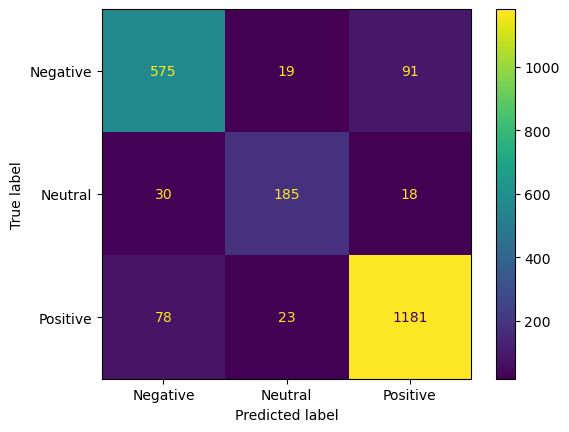

In [97]:
cm_display =ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels = ['Negative', 'Neutral','Positive'])
cm_display.plot()
plt.show()